In [2]:
# import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import rasterio
# import geopandas as gpd
import shapely.geometry
import shapely.ops
# import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES

import xgrid_utils

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [3]:
run ../util/setupConsole_su

In [4]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [5]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [6]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [7]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [7]:
# from datetime import datetime
# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda

# time_dim = pd.date_range("1981-01-01", "2020-12-31", freq="AS")
# q_adv_on_tx_full = xr.open_mfdataset('output/q_adv_on_tx/q_adv_on_warm_season_tx_deciles_*.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
# q_adv_on_tx_full['time'] = time_dim
# q_adv_on_tx_full = q_adv_on_tx_full.rename({'__xarray_dataarray_variable__':'q_adv_on_tx'})
# q_adv_on_tx_full = q_adv_on_tx_full.where(land_sea_mask_binary)
# q_adv_on_tx_full = q_adv_on_tx_full.sel(latitude=slice(60,-60))
# q_adv_on_tx_full.load()
 
# q_adv_on_tx_ts = q_adv_on_tx_full.mean(dim=['latitude', 'longitude'])



In [8]:
# x_var = q_adv_on_tx_ts.q_adv_on_tx.time.dt.year.values
# y_var = q_adv_on_tx_ts.q_adv_on_tx[:,-1].values

# nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
# X = sm.add_constant(x_var[nn])
# mdl = sm.OLS(y_var[nn], X).fit()

# x1 = 1981
# x2 = 2020

# plt.figure(figsize=(3,3))
# plt.plot(x_var, y_var, '-k')
# plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p = 0.075')
# plt.ylabel('Median CDD\nduring warm season')
# font = FontProperties(size=14)
# plt.legend(frameon=False, fontsize=14, prop=font)
# # plt.savefig('tw|tx-tw100-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [9]:
# from datetime import datetime
# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda

# time_dim = pd.date_range("1981-01-01", "2019-12-31", freq="AS")
# cdd_on_tx_full = xr.open_mfdataset('output/cdd_on_tx/cdd_on_tx_warm_season_*.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
# cdd_on_tx_full['time'] = time_dim
# cdd_on_tx_full = cdd_on_tx_full.rename({'__xarray_dataarray_variable__':'cdd_on_tx'})
# cdd_on_tx_full = cdd_on_tx_full.where(land_sea_mask_binary)
# cdd_on_tx_full = cdd_on_tx_full.sel(latitude=slice(60,-60))
# cdd_on_tx_full.load()

# cdd_on_tx_ts = cdd_on_tx_full.mean(dim=['latitude', 'longitude'])



findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


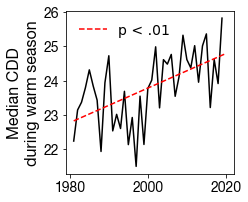

In [10]:
# x_var = cdd_on_tx_ts.cdd_on_tx.time.dt.year.values
# y_var = cdd_on_tx_ts.cdd_on_tx.values

# nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
# X = sm.add_constant(x_var[nn])
# mdl = sm.OLS(y_var[nn], X).fit()

# x1 = 1981
# x2 = 2020

# plt.figure(figsize=(3,3))
# plt.plot(x_var, y_var, '-k')
# plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
# plt.ylabel('Median CDD\nduring warm season')
# font = FontProperties(family='Helvetica', size=14)
# plt.legend(frameon=False, fontsize=14, prop=font)
# # plt.savefig('tw|tx-tw100-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [8]:
era5_monthly_tp_trend = []

era5_monthly_tp_r_tx_tw_slope = []
era5_monthly_tp_r_tx_tw_r2 = []
era5_monthly_tp_r_tx_tw_corr = []


for m in range(0, 12):
    
    with open(f'era5_tp_monthly_trend_{m}.dat', 'rb') as f:
        cur_era5_monthly_tp_trend = pickle.load(f)
        if m == 0:
            era5_monthly_tp_trend = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
        era5_monthly_tp_trend[m,:,:] = cur_era5_monthly_tp_trend
    
    with open(f'era5_monthly_tp_r_tx_tw_{m+1}.dat', 'rb') as f:
        cur_era5_monthly_tp_r_tx_tw = pickle.load(f)
        
        if m == 0:
            era5_monthly_tp_r_tx_tw_slope = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
            era5_monthly_tp_r_tx_tw_r2 = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
        
        era5_monthly_tp_r_tx_tw_slope[m,:,:] = cur_era5_monthly_tp_r_tx_tw['era5_monthly_tp_r_tx_tw_slope']
        era5_monthly_tp_r_tx_tw_r2[m,:,:] = cur_era5_monthly_tp_r_tx_tw['era5_monthly_tp_r_tx_tw_r2']
    
    

era5_monthly_tp_r_tx_tw_lag_slope = []
era5_monthly_tp_r_tx_tw_lag_r2 = []

for l in range(0,5+1):
    with open(f'era5_monthly_tp_r_tx_tw_lag{l}.dat', 'rb') as f:
        cur_era5_monthly_tp_corr_lag = pickle.load(f)
        
        if l == 0:
            era5_monthly_tp_r_tx_tw_lag_slope = np.full([6, cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[0], cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[1]], np.nan)
            era5_monthly_tp_r_tx_tw_lag_r2 = np.full([6, cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[0], cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[1]], np.nan)
            
            era5_monthly_tp_r_tx_tw_corr = cur_era5_monthly_tp_corr_lag['monthly_tp_corr']
        
        era5_monthly_tp_r_tx_tw_lag_slope[l,:,:] = cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope']
        era5_monthly_tp_r_tx_tw_lag_r2[l,:,:] = cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_r2']
        

In [9]:
era5_monthly_tp_r_tx_tw_r2_max = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)
era5_monthly_tp_r_tx_tw_r2_max_ind = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)


for xlat in range(era5_monthly_tp_r_tx_tw_r2.shape[1]):
    for ylon in range(era5_monthly_tp_r_tx_tw_r2.shape[2]):
        cur = era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon]
        if np.where(~np.isnan(cur))[0].size > 10:
            era5_monthly_tp_r_tx_tw_r2_max[xlat, ylon] = np.nanmax(era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon])
            era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon] = np.nanargmax(era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon])



In [10]:
# extract monthly precip trends for month with max r2 at each grid cell

era5_monthly_tp_trend_max_r2 = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)

for xlat in range(era5_monthly_tp_r_tx_tw_r2_max_ind.shape[0]):
    for ylon in range(era5_monthly_tp_r_tx_tw_r2_max_ind.shape[1]):
        if ~np.isnan(era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon]):
            era5_monthly_tp_trend_max_r2[xlat, ylon] = era5_monthly_tp_trend[int(era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon]), xlat, ylon]*10*1000

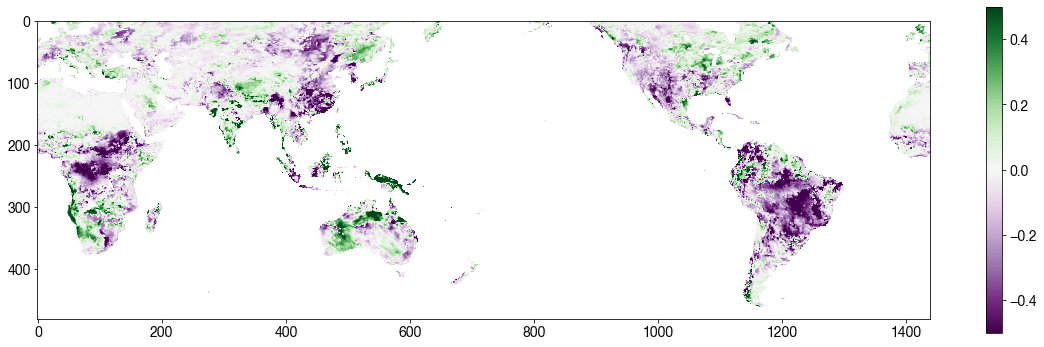

In [14]:
plt.figure(figsize=(20,6))
plt.imshow(era5_monthly_tp_trend_max_r2, cmap='PRGn', vmin=-.5,vmax=.5)
plt.colorbar()

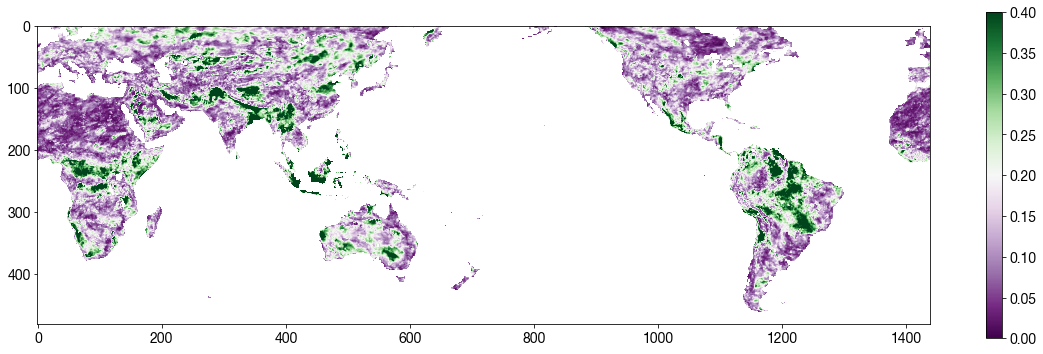

In [15]:
plt.figure(figsize=(20,6))
plt.imshow(np.nanmax(era5_monthly_tp_r_tx_tw_lag_r2,axis=0), cmap='PRGn', vmin=0,vmax=.4)
plt.colorbar()
# plt.imshow(np.nanmean(era5_monthly_tp_r_tx_tw_slope[9:12,:,:], axis=0), cmap='bwr', vmin=-50,vmax=50)

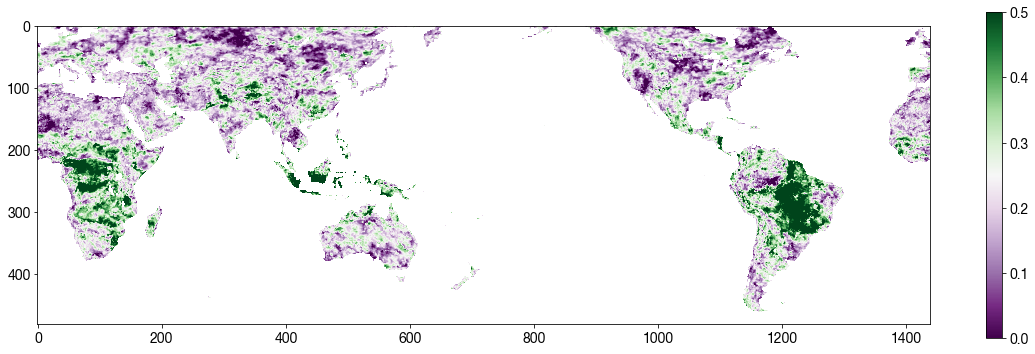

In [16]:
plt.figure(figsize=(20,6))
plt.imshow(np.nanmax(era5_monthly_tp_r_tx_tw_corr,axis=0), cmap='PRGn', vmin=0,vmax=.5)
plt.colorbar()
# plt.imshow(np.nanmean(era5_monthly_tp_r_tx_tw_slope[9:12,:,:], axis=0), cmap='bwr', vmin=-50,vmax=50)


In [11]:
era5_monthly_tp = []
for y in range(1981, 2019+1):
    cur_ds_era5_tp = xr.open_mfdataset(f'era5_tp_monthly_{y}.nc')
    era5_monthly_tp.append(cur_ds_era5_tp)

ds_era5_monthly_tp = xr.concat(era5_monthly_tp, dim='time')
ds_era5_monthly_tp.load()

<xarray.Dataset>
Dimensions:    (latitude: 481, longitude: 1440, time: 468)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2019-12-31
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -59.5 -59.75 -60.0
Data variables:
    tp         (time, latitude, longitude) float64 0.004381 ... 0.002203

In [12]:
recalc = False

In [13]:


from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tx_on_tw_full = xr.open_mfdataset('output/tasmax_on_tw/tasmax_on_warm_season_tw_deciles_*_new.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
    tx_on_tw_full['time'] = time_dim
    tx_on_tw_full = tx_on_tw_full.where(land_sea_mask_binary)
    tx_on_tw_full = tx_on_tw_full.sel(quantile=[1], method='nearest')
    tx_on_tw_full = tx_on_tw_full.sel(latitude=slice(60,-60))
    tx_on_tw_full.load()

    tx_on_tw_full.to_netcdf('intermediate/tx_on_tw_full.nc')

else:
    tx_on_tw_full = xr.open_dataset('intermediate/tx_on_tw_full.nc')
    
tx_on_tw_mean = tx_on_tw_full.mean(dim='time')
tx_on_tw_ts = xgrid_utils.calc_spatial_mean(tx_on_tw_full)
# tx_on_tw_ts.to_netcdf('intermediate/tx_on_tw_ts.nc')


In [14]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tw_on_tx_full = xr.open_mfdataset('output/tw_max_on_tx/tw_max_on_warm_season_tx_deciles_*_new.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
    tw_on_tx_full['time'] = time_dim
    tw_on_tx_full = tw_on_tx_full.where(land_sea_mask_binary)
    tw_on_tx_full = tw_on_tx_full.sel(quantile=[1], method='nearest')
    tw_on_tx_full = tw_on_tx_full.sel(latitude=slice(60,-60))
    tw_on_tx_full.load()

    tw_on_tx_full.to_netcdf('intermediate/tw_on_tx_full.nc')
else:
    tw_on_tx_full = xr.open_dataset('intermediate/tw_on_tx_full.nc')

tw_on_tx_mean = tw_on_tx_full.mean(dim='time')
tw_on_tx_ts = xgrid_utils.calc_spatial_mean(tw_on_tx_full)
# tw_on_tx_ts.to_netcdf('intermediate/tw_on_tx_ts.nc')


In [15]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tx_on_tx_full = xr.open_mfdataset('deciles/tx/era5_tasmax_deciles_warm_season_*_new.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
    tx_on_tx_full['time'] = time_dim
    tx_on_tx_full = tx_on_tx_full.where(land_sea_mask_binary)
    tx_on_tx_full = tx_on_tx_full.sel(quantile=[1], method='nearest')
    tx_on_tx_full = tx_on_tx_full.sel(latitude=slice(60,-60))
    tx_on_tx_full.load()

    tx_on_tx_full.to_netcdf('intermediate/tx_on_tx_full.nc')

else:
    tx_on_tx_full = xr.open_dataset('intermediate/tx_on_tx_full.nc')

tx_on_tx_ts = xgrid_utils.calc_spatial_mean(tx_on_tx_full)
tx_on_tx_mean = tx_on_tx_full.mean(dim='time')
# tx_on_tx_ts.to_netcdf('intermediate/tx_on_tx_ts.nc')



In [16]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tw_on_tw_full = xr.open_mfdataset('deciles/tw/era5_tw_max_deciles_warm_season_*_new.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
    tw_on_tw_full['time'] = time_dim
    tw_on_tw_full = tw_on_tw_full.where(land_sea_mask_binary)
    tw_on_tw_full = tw_on_tw_full.sel(quantile=[1], method='nearest')
    tw_on_tw_full = tw_on_tw_full.sel(latitude=slice(60,-60))
    tw_on_tw_full.load()

    tw_on_tw_full.to_netcdf('intermediate/tw_on_tw_full.nc')
else:
    tw_on_tw_full = xr.open_dataset('intermediate/tw_on_tw_full.nc')

tw_on_tw_ts = xgrid_utils.calc_spatial_mean(tw_on_tw_full)
tw_on_tw_mean = tw_on_tw_full.mean(dim='time')
# tw_on_tw_ts.to_netcdf('intermediate/tw_on_tw_ts.nc')




In [16]:
tx_on_tx_max_ts = tx_on_tx_full.mx2t.max(dim=['latitude', 'longitude'])
tw_on_tw_max_ts = tw_on_tw_full.tw.max(dim=['latitude', 'longitude'])

In [17]:
X = sm.add_constant(range(tx_on_tx_max_ts.size))
mdl_tw = sm.OLS(tw_on_tw_max_ts.values, X).fit()
mdl_tx = sm.OLS(tx_on_tx_max_ts.values, X).fit()
mdl_tw.params[1]/mdl_tx.params[1]

0.7038454164180521

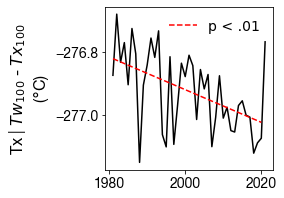

In [51]:
x_var = tx_on_tw_ts.mx2t.time.dt.year.values
y_var = (tx_on_tw_ts.mx2t[:,-1].values - tx_on_tx_ts.mx2t[:,-1].values)-273.15

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('Tx | $Tw_{100}$ - $Tx_{100}$\n($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tw-tx100-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [21]:
# x_var = tx_on_tw_ts.mx2t.time.dt.year.values
# # y_var = (tx_on_tx_ts.mx2t[:,-1].values - tx_on_tx_ts.mx2t[:,-2].values)
# y_var = (tw_on_tw_ts.tw[:,-1].values - tw_on_tw_ts.tw[:,-2].values)

# nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
# X = sm.add_constant(x_var[nn])
# mdl = sm.OLS(y_var[nn], X).fit()

# x1 = 1981
# x2 = 2020

# plt.figure(figsize=(3,3))
# plt.plot(x_var, y_var, '-k')
# plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
# plt.ylabel('Tx | $Tw_{100}$ - $Tx_{100}$\n($\degree$C)')
# font = FontProperties(family='Arial', size=14)
# plt.legend(frameon=False, fontsize=14, prop=font)
# # plt.savefig('tx|tw-tx100-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [89]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2020-12-31", freq="AS")
tx_sm_corr_full = xr.open_mfdataset('output/tx_sm_corr/tx_sm_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_sm_corr_full['time'] = time_dim
tx_sm_corr_full = tx_sm_corr_full.rename({'__xarray_dataarray_variable__':'tx_sm_corr'})
tx_sm_corr_full = tx_sm_corr_full.where(land_sea_mask_binary)
tx_sm_corr_full = tx_sm_corr_full.sel(latitude=slice(60,-60))
tx_sm_corr_full.load()
tx_sm_corr_mean = tx_sm_corr_full.mean(dim='time')
tx_sm_corr_ts = xgrid_utils.calc_spatial_mean(tx_sm_corr_full)

tx_sm_corr_mean.to_netcdf('intermediate/tx_sm_corr_mean.nc')
tx_sm_corr_ts.to_netcdf('intermediate/tx_sm_corr_ts.nc')

In [90]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2020-12-31", freq="AS")
tx_huss_corr_full = xr.open_mfdataset('output/tx_huss_corr/tx_huss_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_huss_corr_full['time'] = time_dim
tx_huss_corr_full = tx_huss_corr_full.rename({'__xarray_dataarray_variable__':'tx_huss_corr'})
tx_huss_corr_full = tx_huss_corr_full.where(land_sea_mask_binary)
tx_huss_corr_full = tx_huss_corr_full.sel(latitude=slice(60,-60))
tx_huss_corr_full.load()
# tx_huss_corr_full.to_netcdf('intermediate/tx_huss_corr_full.nc')


tx_huss_corr_mean = tx_huss_corr_full.mean(dim='time')
tx_huss_corr_ts = xgrid_utils.calc_spatial_mean(tx_huss_corr_full)

# tx_huss_corr_ts = tx_huss_corr_full.mean(dim=['latitude', 'longitude'])

# tx_huss_corr_mean.to_netcdf('intermediate/tx_huss_corr_mean.nc')
# tx_huss_corr_ts.to_netcdf('intermediate/tx_huss_corr_ts.nc')

In [13]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)

tx_tw_corr_full = tx_tw_corr_full.sel(latitude=slice(60,-60))
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')
tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full)






In [41]:
# load bootstrapped trends
era5_r_tx_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)

lat_skip = 20
for d in range(24):
with open(f'era5_r_tx_tw_slope_bootstrap_100_decile{d}_2_26_4pm.dat', 'rb') as f:
        cur_era5_r_tx_tw_slice = pickle.load(f)
        era5_r_tx_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_slope'][0:20,:,:]
        era5_r_tx_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_int'][0:20,:,:]
        
        era5_r_tx_tw_vs_tw_on_tx_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tw_on_tx_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_int'][0:20,:,:]
        
        era5_r_tx_tw_vs_tx_on_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tx_on_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_int'][0:20,:,:]

In [42]:
era5_r_tx_tw_slope = np.moveaxis(era5_r_tx_tw_slope, 2, 0)
era5_r_tx_tw_int = np.moveaxis(era5_r_tx_tw_int, 2, 0)

era5_r_tx_tw_vs_tw_on_tx_slope = np.moveaxis(era5_r_tx_tw_vs_tw_on_tx_slope, 2, 0)
era5_r_tx_tw_vs_tw_on_tx_int = np.moveaxis(era5_r_tx_tw_vs_tw_on_tx_int, 2, 0)

era5_r_tx_tw_vs_tx_on_tw_slope = np.moveaxis(era5_r_tx_tw_vs_tx_on_tw_slope, 2, 0)
era5_r_tx_tw_vs_tx_on_tw_int = np.moveaxis(era5_r_tx_tw_vs_tx_on_tw_int, 2, 0)

In [35]:
era5_r_tx_tw_slope_da = xr.DataArray(
    data=era5_r_tx_tw_slope,  # Use your data array here
    dims=["bootstrap", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "bootstrap":np.arange(0,100),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

era5_r_tx_tw_slope_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)

era5_r_tx_tw_int_da = xr.DataArray(
    data=era5_r_tx_tw_int,  # Use your data array here
    dims=["bootstrap", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "bootstrap":np.arange(0,100),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

era5_r_tx_tw_int_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_int_da)

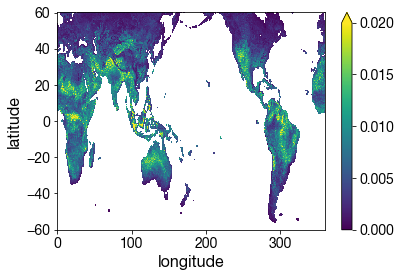

In [24]:
(era5_r_tx_tw_slope_da.max(dim='bootstrap') - era5_r_tx_tw_slope_da.min(dim='bootstrap')).plot(vmin = 0, vmax=.02)

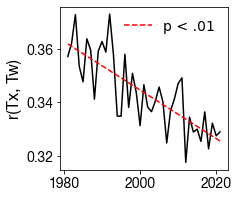

In [20]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))

# for b in range(era5_r_tx_tw_slope_spatial_mean.bootstrap.size):
#     plt.plot([x1, x2], [era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*0, era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*(x2-x1)], '-', c='#aaaaaa')
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Tw)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.savefig('r(tx,tw)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [13]:
tw_on_tx100_minus_tw100 = tw_on_tx_full['tw'][:,-1,:, :]-tw_on_tw_full['tw'][:,-1,:,:]
tx_on_tw100_minus_tx100 = tx_on_tw_full['mx2t'][:,-1,:, :]-tx_on_tx_full['mx2t'][:,-1,:,:]

import numpy as np
import xarray as xr
from scipy import signal

def nan_detrend(y):
    """Detrend while handling NaN values."""
    not_nan = ~np.isnan(y)
    
    if not_nan.sum() <= 1:  # Return original if only one or no non-NaN values
        return y
    
    y_detrended = np.empty_like(y)
    y_detrended[:] = np.nan
    y_detrended[not_nan] = signal.detrend(y[not_nan])
    
    return y_detrended

# Replace infinite values with NaN
tw_on_tx100_minus_tw100 = tw_on_tx100_minus_tw100.where(np.isfinite(tw_on_tx100_minus_tw100))
tx_tw_corr_full_detrend = tx_tw_corr_full.where(np.isfinite(tx_tw_corr_full))

# Apply the detrending function
tw_on_tx100_minus_tw100_detrend = xr.apply_ufunc(
    nan_detrend, 
    tw_on_tx100_minus_tw100,               
    input_core_dims=[['time']],    
    output_core_dims=[['time']],   
    vectorize=True           
)

tx_tw_corr_full_detrend = xr.apply_ufunc(
    nan_detrend, 
    tx_tw_corr_full_detrend,               
    input_core_dims=[['time']],    
    output_core_dims=[['time']],   
    vectorize=True           
)



In [14]:
tx_tw_corr_full_detrend_1d = tx_tw_corr_full_detrend.tx_tw_corr[:,:,0:-1].values.reshape(tx_tw_corr_full_detrend.tx_tw_corr[:,:,0:-1].values.size)

In [15]:
tw_on_tx100_minus_tw100_detrend_1d = tw_on_tx100_minus_tw100_detrend.values.reshape([tw_on_tx100_minus_tw100_detrend.values.size])

In [16]:
tx_tw_corr_mean_1d = tx_tw_corr_mean.tx_tw_corr.values.reshape([tx_tw_corr_mean.tx_tw_corr.values.size])

In [17]:
x_var = tx_tw_corr_full_detrend_1d
y_var = tw_on_tx100_minus_tw100_detrend_1d

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

# plt.scatter(tx_tw_corr_full_detrend_1d, tw_on_tx100_minus_tw100_detrend_1d)

In [71]:


lat_ranges_step = -5
lat_ranges = np.arange(60, -60, lat_ranges_step)

tx_tw_corr_trend_lat_ranges = np.full(lat_ranges.size, np.nan)
tx_tw_corr_pval_lat_ranges = np.full(lat_ranges.size, np.nan)

huss_sm_corr_trend_lat_ranges = np.full(lat_ranges.size, np.nan)
huss_sm_corr_pval_lat_ranges = np.full(lat_ranges.size, np.nan)

for l in range(lat_ranges.size-1):
    l1 = lat_ranges[l]
    l2 = lat_ranges[l+1]
    
    tx_tw_corr_cur = tx_tw_corr_full.tx_tw_corr.sel(latitude=slice(l1,l2)).mean(dim=['latitude', 'longitude'])
    huss_sm_corr_cur = huss_sm_corr_full.huss_sm_corr.sel(latitude=slice(l1,l2)).mean(dim=['latitude', 'longitude'])
    
    nn = np.where((~np.isnan(tx_tw_corr_cur.values)))[0]
    if nn.size > 0:
        X = sm.add_constant(range(nn.size))
        mdl = sm.OLS(tx_tw_corr_cur.values[nn], X).fit()

        tx_tw_corr_trend_lat_ranges[l] = mdl.params[1]*10
        tx_tw_corr_pval_lat_ranges[l] = mdl.pvalues[1]
        
    nn = np.where((~np.isnan(huss_sm_corr_cur.values)))[0]
    if nn.size > 0:
        X = sm.add_constant(range(nn.size))
        mdl = sm.OLS(huss_sm_corr_cur.values[nn], X).fit()

        huss_sm_corr_trend_lat_ranges[l] = mdl.params[1]*10
        huss_sm_corr_pval_lat_ranges[l] = mdl.pvalues[1]




NameError: name 'huss_sm_corr_full' is not defined

NameError: name 'tx_tw_corr_pval_lat_ranges' is not defined

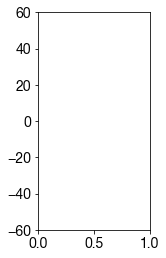

In [17]:
plt.figure(figsize=(2,4))
plt.ylim([-60,60])

# Calculate indexes where p value is less than .05
idx = tx_tw_corr_pval_lat_ranges < .05

# Plot data where p value is less than .05 in black
plt.plot(tx_tw_corr_trend_lat_ranges[idx], lat_ranges[idx]-lat_ranges_step/2, 'o', color='#ed443b')

# Plot data where p value is greater than or equal to .05 in red
plt.plot(tx_tw_corr_trend_lat_ranges[~idx], lat_ranges[~idx]-lat_ranges_step/2, 'o', color='k')


plt.plot([0,0], [-60, 60], '--k')
# plt.yticks([])
plt.ylabel('Latitude')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

# plt.xticks([-60,-30,0,30,60])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
# plt.savefig('r(tx,tw)-trend-by-lat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [34]:
plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values[0:-1])

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Huss)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean r(Tx, Tw)\ndetrended anomaly')
font = FontProperties(size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-r(tx,huss).png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

NameError: name 'tx_huss_corr_ts' is not defined

<Figure size 216x216 with 0 Axes>

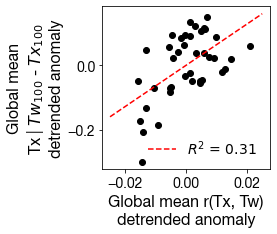

In [34]:

plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values[0:-1])
# x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend((tx_on_tw_ts.mx2t[:-1,-1].values - tx_on_tx_ts.mx2t[:,-1].values)-273.15)
# y_var = signal.detrend(tw_on_tx_ts.tw[:,-1].values - tw_on_tw_ts.tw[:].values)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTx | $Tw_{100}$ - $Tx_{100}$\ndetrended anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-tx|tw100-tx100.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


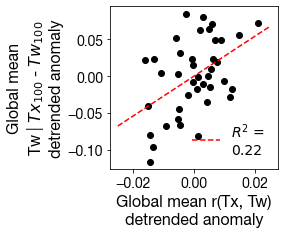

In [37]:

plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values[0:-1])
# x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend((tw_on_tx_ts.tw[:,-1].values - tw_on_tw_ts.tw[:, -1].values)-273.15)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ =\n%.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTw | $Tx_{100}$ - $Tw_{100}$\ndetrended anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-tw|tx100-tw100.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [50]:
tx_on_tw100_chg_from_r_tx_tw_spatial_mean = \
                xgrid_utils.calc_spatial_mean(xr.DataArray(era5_r_tx_tw_vs_tx_on_tw_slope * (era5_r_tx_tw_slope*40), 
              dims=["bootstrap", "latitude", "longitude"], coords={"bootstrap":np.arange(100), "latitude": tx_tw_corr_full.latitude.values, "longitude":tx_tw_corr_full.longitude.values}))

tw_on_tx100_chg_from_r_tx_tw_spatial_mean = \
                xgrid_utils.calc_spatial_mean(xr.DataArray(era5_r_tx_tw_vs_tw_on_tx_slope * (era5_r_tx_tw_slope*40), 
              dims=["bootstrap", "latitude", "longitude"], coords={"bootstrap":np.arange(100), "latitude": tx_tw_corr_full.latitude.values, "longitude":tx_tw_corr_full.longitude.values}))


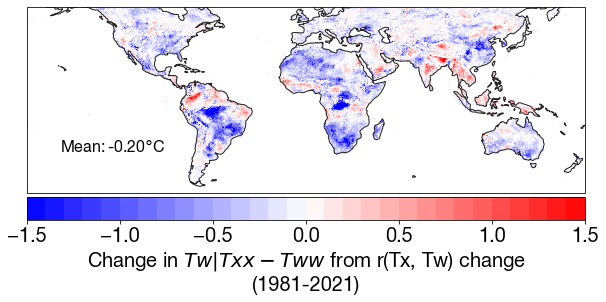

In [62]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean((era5_r_tx_tw_vs_tw_on_tx_slope * (era5_r_tx_tw_slope*(2021-1981+1))), axis=0)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in $Tw | Txx-Tww$ from r(Tx, Tw) change\n(1981-2021)', fontsize=20)

plt.savefig('tw_on_tx_from_r_tx_tw_chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

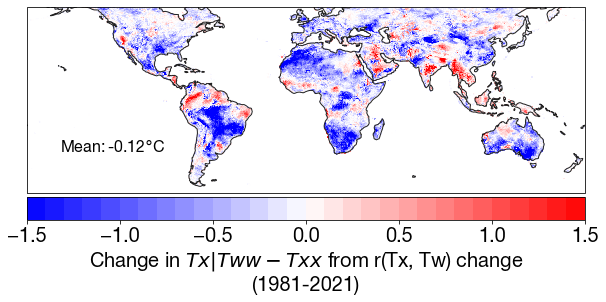

In [61]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = np.nanmean((era5_r_tx_tw_vs_tx_on_tw_slope * (era5_r_tx_tw_slope*(2021-1981+1))), axis=0)

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tw_on_tx100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in $Tx | Tww-Txx$ from r(Tx, Tw) change\n(1981-2021)', fontsize=20)

plt.savefig('tx_on_tw_from_r_tx_tw_chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

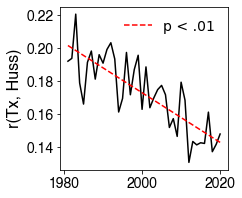

In [167]:
x_var = tx_huss_corr_ts.tx_huss_corr.time.dt.year.values
y_var = tx_huss_corr_ts.tx_huss_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Huss)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,huss)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

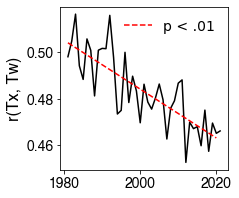

In [63]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Tw)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,tw)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [64]:
#CALC ERA5 GLOBAL MEAN TX TIME SERIES
recalc = False
if recalc:
    tx_era5 = xr.open_mfdataset('%s/daily/tasmax_*.nc'%dirEra5)
    tx_era5 = tx_era5.sel(time=slice('1981', '2021')).sel(latitude=slice(60, -60))
    tx_era5['mx2t'] -= 273.15
    tx_era5 = tx_era5.where(land_sea_mask_binary)
    tx_era5_annual = tx_era5.mx2t.resample(time='Y').mean()
    tx_era5_ts = xgrid_utils.calc_spatial_mean(tx_era5_annual)
    tx_era5_ts.to_netcdf('era5_global_mean_tx_ts.nc')
    tx_era5_annual.to_netcdf('era5_global_mean_tx_annual.nc')
else:
    tx_era5_ts = xr.open_dataset('era5_global_mean_tx_ts.nc')
    tx_era5_annual = xr.open_dataset('era5_global_mean_tx_annual.nc')


In [ ]:
r_tx_tw_per_deg = np.full([tx_era5_annual.latitude.size, tx_era5_annual.longitude.size],np.nan)
r_tx_tw_per_gmt_deg = np.full([tx_era5_annual.latitude.size, tx_era5_annual.longitude.size],np.nan)

cur_tx_gmt = tx_era5_ts.mx2t[:].values
cur_tx_gmt_detrend = signal.detrend(cur_tx_gmt)

for xlat in range(tx_era5_annual.latitude.size):
    if xlat % 25 == 0: print(xlat)
    for ylon in range(tx_era5_annual.longitude.size):
        
        cur_tx_tw_corr = tx_tw_corr_full.tx_tw_corr[:,xlat,ylon].values
        cur_tx = tx_era5_annual.mx2t[:,xlat,ylon].values
        
        nn = np.where((~np.isnan(cur_tx_tw_corr)) & (~np.isnan(cur_tx)))[0]
        
        if nn.size > 20:

            cur_tx_tw_corr_detrend = signal.detrend(cur_tx_tw_corr[nn])
            cur_tx_detrend = signal.detrend(cur_tx[nn])
        
            X = sm.add_constant(cur_tx_detrend)
            mdl = sm.OLS(cur_tx_tw_corr_detrend,X).fit()
            r_tx_tw_per_deg[xlat, ylon] = mdl.params[1]
            
            X = sm.add_constant(cur_tx_gmt_detrend)
            mdl = sm.OLS(cur_tx_tw_corr_detrend,X).fit()
            r_tx_tw_per_gmt_deg[xlat, ylon] = mdl.params[1]


0


In [72]:
with open('era5_r_tx_tw_per_deg.dat', 'wb') as f:
    pickle.dump(r_tx_tw_per_deg, f)
with open('era5_r_tx_tw_per_gmt_deg.dat', 'wb') as f:
    pickle.dump(r_tx_tw_per_gmt_deg, f)

In [21]:
X = sm.add_constant(range(tx_era5_ts.time.size))
mdl_era5_global_mean_tx = sm.OLS(tx_era5_ts.mx2t.values, X).fit()

x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl_era5_tx_tw_corr = sm.OLS(y_var[nn], X).fit()

In [23]:
mdl_era5_tx_tw_corr.params[1]/mdl_era5_global_mean_tx.params[1]

-0.038118621780981944

In [182]:
tw_era5_mean = xr.open_dataset('era5_tw_max_mean.nc')
tw_era5_mean.load()
tw_era5_mean['tw'] = tw_era5_mean['tw'].where(land_sea_mask_binary, np.nan)
tw_era5_mean['tw'] = tw_era5_mean['tw'].sel(latitude=slice(60,-60))

tx_era5_mean = xr.open_dataset('era5_tasmax_mean.nc')
tx_era5_mean.load()
tx_era5_mean['mx2t'] -= 273.15

huss_era5_mean = xr.open_dataset('era5_huss_mean.nc')
huss_era5_mean.load()

sm_era5_mean = xr.open_dataset('era5_sm_mean_regrid.nc')
sm_era5_mean['swvl1'] = sm_era5_mean['swvl1'].sel(latitude=slice(60,-60))
sm_era5_mean.load();



In [17]:
tran_warm_season_trend = xr.open_dataset('era5_tran_on_warm_season_trends.nc')
tran_warm_season_trend.load()
tran_warm_season_trend['tran_on_warm_season_trend'] = -tran_warm_season_trend['tran_on_warm_season_trend'].sel(latitude=slice(60,-60))
tran_warm_season_trend['tran_on_warm_season_p_value'] = tran_warm_season_trend['tran_on_warm_season_p_value'].sel(latitude=slice(60,-60))


tet_warm_season_trend = xr.open_dataset('era5_tet_on_warm_season_trends.nc')
tet_warm_season_trend.load()
tet_warm_season_trend['tet_on_warm_season_trend'] = tet_warm_season_trend['tet_on_warm_season_trend'].sel(latitude=slice(60,-60))
tet_warm_season_trend['tet_on_warm_season_p_value'] = tet_warm_season_trend['tet_on_warm_season_p_value'].sel(latitude=slice(60,-60))


In [18]:

txx_day_trend = xr.open_dataset('era5_txx_day_warm_season_trends.nc')
txx_day_trend.load()
txx_day_trend['txx_day_warm_season_trend'] = txx_day_trend['txx_day_warm_season_trend'].sel(latitude=slice(60,-60))
txx_day_trend['txx_day_warm_season_p_value'] = txx_day_trend['txx_day_warm_season_p_value'].sel(latitude=slice(60,-60))


In [19]:
tx_tw_corr_trend = xr.open_dataset('era5_tx_tw_corr_warm_season_trend.nc')
tx_tw_corr_trend.load()
tx_tw_corr_trend['tx_tw_corr_warm_season_trend'] = tx_tw_corr_trend['tx_tw_corr_warm_season_trend'].sel(latitude=slice(60,-60))
tx_tw_corr_trend['tx_tw_corr_warm_season_p_value'] = tx_tw_corr_trend['tx_tw_corr_warm_season_p_value'].sel(latitude=slice(60,-60))

tx_huss_corr_trend = xr.open_dataset('era5_tx_huss_corr_warm_season_trends.nc')
tx_huss_corr_trend.load()
tx_huss_corr_trend['tx_huss_corr_warm_season_trend'] = tx_huss_corr_trend['tx_huss_corr_warm_season_trend'].sel(latitude=slice(60,-60))
tx_huss_corr_trend['tx_huss_corr_warm_season_p_value'] = tx_huss_corr_trend['tx_huss_corr_warm_season_p_value'].sel(latitude=slice(60,-60))

tx_sm_corr_trend = xr.open_dataset('era5_tx_sm_corr_warm_season_trends.nc')
tx_sm_corr_trend.load()
tx_sm_corr_trend['tx_sm_corr_warm_season_trend'] = tx_sm_corr_trend['tx_sm_corr_warm_season_trend'].sel(latitude=slice(60,-60))
tx_sm_corr_trend['tx_sm_corr_warm_season_p_value'] = tx_sm_corr_trend['tx_sm_corr_warm_season_p_value'].sel(latitude=slice(60,-60))

huss_sm_corr_trend = xr.open_dataset('era5_huss_sm_corr_warm_season_trends.nc')
huss_sm_corr_trend.load()
huss_sm_corr_trend['huss_sm_corr_warm_season_trend'] = huss_sm_corr_trend['huss_sm_corr_warm_season_trend'].sel(latitude=slice(60,-60))
huss_sm_corr_trend['huss_sm_corr_warm_season_p_value'] = huss_sm_corr_trend['huss_sm_corr_warm_season_p_value'].sel(latitude=slice(60,-60))


In [20]:
tp_on_tx_trend = xr.open_dataset('era5_tp_on_tx_warm_season_trend.nc')
tp_on_tx_trend.load()
tp_on_tx_trend = tp_on_tx_trend.sel(latitude=slice(60,-60))
# tp_on_tx_trend['tp_on_tx_warm_season_trend'] = tp_on_tx_trend['tp_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
# tp_on_tx_trend['tp_on_tx_warm_season_p_value'] = tp_on_tx_trend['tp_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))

tp_on_tx_deciles_trend = xr.open_dataset('era5_tp_on_tx_warm_season_deciles_trends.nc')
tp_on_tx_deciles_trend.load()
tp_on_tx_deciles_trend['tp_on_tx_warm_season_trend'] = tp_on_tx_deciles_trend['tp_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
tp_on_tx_deciles_trend['tp_on_tx_warm_season_p_value'] = tp_on_tx_deciles_trend['tp_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))

tp_on_tw_trend = xr.open_dataset('era5_tp_on_tw_warm_season_trend.nc')
tp_on_tw_trend.load()
tp_on_tw_trend['tp_on_tw_warm_season_trend'] = tp_on_tw_trend['tp_on_tw_warm_season_trend'].sel(latitude=slice(60,-60))
tp_on_tw_trend['tp_on_tw_warm_season_p_value'] = tp_on_tw_trend['tp_on_tw_warm_season_p_value'].sel(latitude=slice(60,-60))

In [21]:
ef_on_tx_trend = xr.open_dataset('era5_ef_on_warm_season_tx_trends_by_decile.nc')
ef_on_tx_trend = ef_on_tx_trend.rename({'ef_on_tx_warm_season_trend':'ef_on_warm_season_tx_trend',
                                       'ef_on_tx_warm_season_p_value':'ef_on_warm_season_tx_p_value'})
ef_on_tx_trend.load()
ef_on_tx_trend['ef_on_warm_season_tx_trend'] = ef_on_tx_trend['ef_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
ef_on_tx_trend['ef_on_warm_season_tx_p_value'] = ef_on_tx_trend['ef_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))


In [22]:
tcc_on_tx_trend = xr.open_dataset('era5_tcc_on_warm_season_trends.nc')
tcc_on_tx_trend.load()
tcc_on_tx_trend['tcc_on_tx_warm_season_trend'] = tcc_on_tx_trend['tcc_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
tcc_on_tx_trend['tcc_on_tx_warm_season_p_value'] = tcc_on_tx_trend['tcc_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))


In [23]:
cdd_on_tx_trend = xr.open_dataset('era5_cdd_on_tx_warm_season_trends.nc')
cdd_on_tx_trend.load()
cdd_on_tx_trend['cdd_on_tx_warm_season_trend'] = cdd_on_tx_trend['cdd_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
cdd_on_tx_trend['cdd_on_tx_warm_season_p_value'] = cdd_on_tx_trend['cdd_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))


In [24]:
gph500_on_tx_trend = xr.open_dataset('era5_gph500_on_tx_warm_season_deciles_trends.nc')
gph500_on_tx_trend.load()
gph500_on_tx_trend['gph500_on_tx_warm_season_trend'] = gph500_on_tx_trend['gph500_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
gph500_on_tx_trend['gph500_on_tx_warm_season_p_value'] = gph500_on_tx_trend['gph500_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))

gph500_on_tw_trend = xr.open_dataset('era5_gph500_on_tw_warm_season_deciles_trends.nc')
gph500_on_tw_trend.load()
gph500_on_tw_trend['gph500_on_tw_warm_season_trend'] = gph500_on_tw_trend['gph500_on_tw_warm_season_trend'].sel(latitude=slice(60,-60))
gph500_on_tw_trend['gph500_on_tw_warm_season_p_value'] = gph500_on_tw_trend['gph500_on_tw_warm_season_p_value'].sel(latitude=slice(60,-60))


In [25]:
q_adv_on_tx_trend = xr.open_dataset('era5_q_adv_on_tx_warm_season_trends.nc')
q_adv_on_tx_trend.load()
q_adv_on_tx_trend['q_adv_on_tx_warm_season_trend'] = q_adv_on_tx_trend['q_adv_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
q_adv_on_tx_trend['q_adv_on_tx_warm_season_p_value'] = q_adv_on_tx_trend['q_adv_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))

In [26]:
huss_on_tx_trend = xr.open_dataset('era5_huss_on_warm_season_tx_trends_by_decile_new.nc')
huss_on_tx_trend.load()
huss_on_tx_trend['huss_on_warm_season_tx_trend'] = huss_on_tx_trend['huss_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
huss_on_tx_trend['huss_on_warm_season_tx_p_value'] = huss_on_tx_trend['huss_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

huss_on_tw_trend = xr.open_dataset('era5_huss_on_warm_season_tw_trends_by_decile_new.nc')
huss_on_tw_trend.load()
huss_on_tw_trend['huss_on_warm_season_tw_trend'] = huss_on_tw_trend['huss_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
huss_on_tw_trend['huss_on_warm_season_tw_p_value'] = huss_on_tw_trend['huss_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))


In [27]:
evap_on_tw_trend = xr.open_dataset('era5_evaporation_on_warm_season_tw_trends_by_decile_new.nc')
evap_on_tw_trend.load()
evap_on_tw_trend['evaporation_on_warm_season_tw_trend'] *= -1
evap_on_tw_trend['evaporation_on_warm_season_tw_trend'] = evap_on_tw_trend['evaporation_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
evap_on_tw_trend['evaporation_on_warm_season_tw_p_value'] = evap_on_tw_trend['evaporation_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

evap_on_tx_trend = xr.open_dataset('era5_evaporation_on_warm_season_tx_trends_by_decile_new.nc')
evap_on_tx_trend.load()
evap_on_tx_trend['evaporation_on_warm_season_tx_trend'] *= -1
evap_on_tx_trend['evaporation_on_warm_season_tx_trend'] = evap_on_tx_trend['evaporation_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
evap_on_tx_trend['evaporation_on_warm_season_tx_p_value'] = evap_on_tx_trend['evaporation_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))


In [28]:
tw = xr.open_dataset('era5_tw_warm_season_trends_by_decile_new.nc')
tw.load()
tw['tw_on_warm_season_trend'] = tw['tw_on_warm_season_trend'].sel(latitude=slice(60,-60))
tw['tw_on_warm_season_p_value'] = tw['tw_on_warm_season_p_value'].sel(latitude=slice(60,-60))

tx = xr.open_dataset('era5_tx_warm_season_trends_by_decile_new.nc')
tx.load()
tx['tx_on_warm_season_trend'] = tx['tx_on_warm_season_trend'].sel(latitude=slice(60,-60))
tx['tx_on_warm_season_p_value'] = tx['tx_on_warm_season_p_value'].sel(latitude=slice(60,-60))

In [29]:
tw_on_tx_trend = xr.open_dataset('era5_tw_on_warm_season_tx_trends_by_decile_new.nc')
tw_on_tx_trend.load()
tw_on_tx_trend['tw_on_warm_season_tx_trend'] = tw_on_tx_trend['tw_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
tw_on_tx_trend['tw_on_warm_season_tx_p_value'] = tw_on_tx_trend['tw_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

tx_on_tw_trend = xr.open_dataset('era5_tx_on_warm_season_tw_trends_by_decile_new.nc')
tx_on_tw_trend.load()
tx_on_tw_trend['tx_on_warm_season_tw_trend'] = tx_on_tw_trend['tx_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
tx_on_tw_trend['tx_on_warm_season_tw_p_value'] = tx_on_tw_trend['tx_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

In [30]:
sm_on_tx_trends = xr.open_dataset('era5_sm_on_warm_season_tx_trends_by_decile_new.nc')
sm_on_tx_trends.load()
sm_on_tx_trends['sm_on_warm_season_tx_trend'] = sm_on_tx_trends['sm_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
sm_on_tx_trends['sm_on_warm_season_tx_p_value'] = sm_on_tx_trends['sm_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

sm_on_tw_trends = xr.open_dataset('era5_sm_on_warm_season_tw_trends_by_decile_new.nc')
sm_on_tw_trends.load()
sm_on_tw_trends['sm_on_warm_season_tw_trend'] = sm_on_tw_trends['sm_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
sm_on_tw_trends['sm_on_warm_season_tw_p_value'] = sm_on_tw_trends['sm_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

In [72]:
x_var = tx_on_tw_ts.mx2t.time.dt.year.values
y_var = tx_on_tw_ts.mx2t[:,-1].values - tx['tx_on_warm_season_trend'][tx_on_tw_ts.mx2t[:,-11].values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r')
plt.ylabel('Tx on Tw')


SyntaxError: invalid syntax (<ipython-input-72-cbeb385caee4>, line 4)

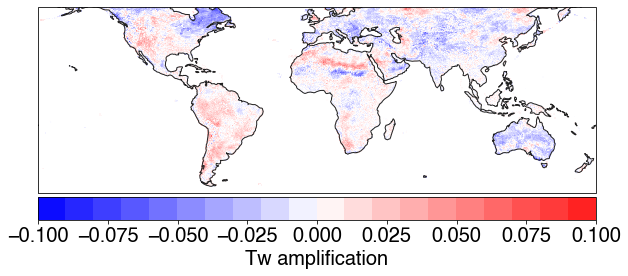

In [97]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw['tw_on_warm_season_trend'][-1,:,:]-tw['tw_on_warm_season_trend'][-11,:,:]

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tw amplification', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

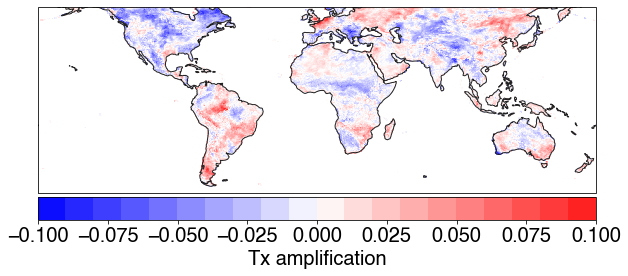

In [98]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tx['tx_on_warm_season_trend'][-1,:,:]-tx['tx_on_warm_season_trend'][-11,:,:]

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx amplification', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

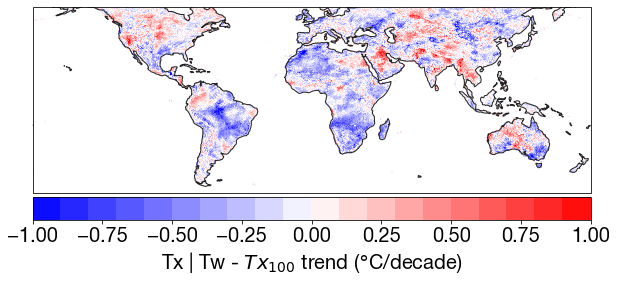

In [96]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tx_on_tw_trend['tx_on_warm_season_tw_trend'][-1,:,:] - tx['tx_on_warm_season_trend'][-1,:,:])*10

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Tx | Tw - $Tx_{100}$ trend ($\degree$C/decade)', fontsize=20)

plt.savefig('tx|tw-tx100-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

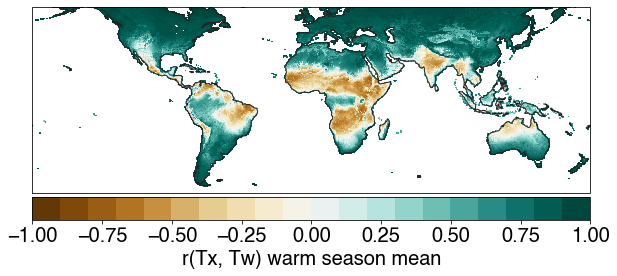

In [99]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean.tx_tw_corr

masked_data = data.where(land_sea_mask_binary)

c = plt.pcolormesh(lon, lat, masked_data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season mean', fontsize=20)


# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



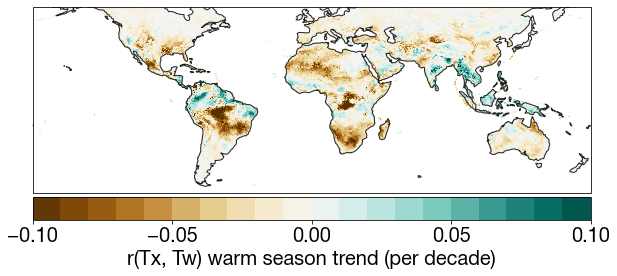

In [104]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_trend.tx_tw_corr_warm_season_trend*10
p_val = tx_tw_corr_trend.tx_tw_corr_warm_season_p_value

mask = p_val < 0.1
masked_data = data.where(mask)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season trend (per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



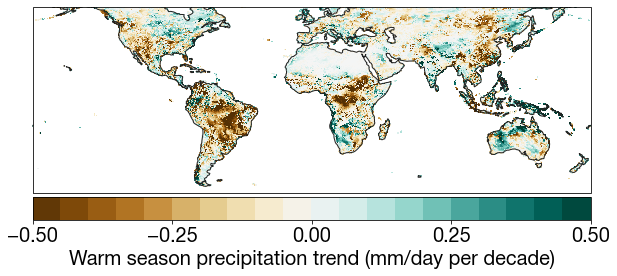

In [130]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_monthly_tp_trend_max_r2*10*1000

c = plt.pcolormesh(lon, tp_on_tx_trend.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Warm season precipitation trend (mm/day per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



<xarray.DataArray 'huss_on_warm_season_tx_trend' (latitude: 721, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    year       int64 2021
    quantile   float64 0.95

In [86]:
tx_tw_corr_trend_1d = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.sel(latitude=slice(60,-60)).values.reshape([tx_tw_corr_trend.tx_tw_corr_warm_season_trend.sel(latitude=slice(60,-60)).values.size])*10
era5_monthly_tp_trend_max_r2_1d = era5_monthly_tp_trend_max_r2.reshape([era5_monthly_tp_trend_max_r2.size])

era5_evap_trend_1d = evap_on_tx_trend['evaporation_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([evap_on_tx_trend['evaporation_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
era5_tran_trend_1d = tran_warm_season_trend['tran_on_warm_season_trend'].sel(latitude=slice(60,-60)).values.reshape([tran_warm_season_trend['tran_on_warm_season_trend'].sel(latitude=slice(60,-60)).values.size])
era5_sm_trend_1d = sm_on_tx_trends['sm_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([sm_on_tx_trends['sm_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
era5_huss_trend_1d = huss_on_tx_trend['huss_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([huss_on_tx_trend['huss_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])




In [87]:
tx_tw_corr_trend_percentile_levels = np.nanpercentile(tx_tw_corr_trend_1d, np.arange(1,99))
abs_diff = np.abs(tx_tw_corr_trend_1d[:, np.newaxis] - tx_tw_corr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
tx_tw_corr_trend_percentiles_1d = min_diff_indices.astype(float)
tx_tw_corr_trend_percentiles_1d[tx_tw_corr_trend_percentiles_1d == 0] = np.nan



evap_trend_percentile_levels = np.nanpercentile(era5_evap_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_evap_trend_1d[:, np.newaxis] - evap_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
evap_trend_percentiles_1d = min_diff_indices.astype(float)
evap_trend_percentiles_1d[evap_trend_percentiles_1d == 0] = np.nan



tran_trend_percentile_levels = np.nanpercentile(era5_tran_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_tran_trend_1d[:, np.newaxis] - tran_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
tran_trend_percentiles_1d = min_diff_indices.astype(float)
tran_trend_percentiles_1d[tran_trend_percentiles_1d == 0] = np.nan



pr_trend_percentile_levels = np.nanpercentile(era5_monthly_tp_trend_max_r2_1d, np.arange(1,99))
abs_diff = np.abs(era5_monthly_tp_trend_max_r2_1d[:, np.newaxis] - pr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
pr_trend_percentiles_1d = min_diff_indices.astype(float)
pr_trend_percentiles_1d[pr_trend_percentiles_1d == 0] = np.nan



sm_trend_percentile_levels = np.nanpercentile(era5_sm_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_sm_trend_1d[:, np.newaxis] - sm_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
sm_trend_percentiles_1d = min_diff_indices.astype(float)
sm_trend_percentiles_1d[sm_trend_percentiles_1d == 0] = np.nan




huss_trend_percentile_levels = np.nanpercentile(era5_huss_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_huss_trend_1d[:, np.newaxis] - huss_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
huss_trend_percentiles_1d = min_diff_indices.astype(float)
huss_trend_percentiles_1d[huss_trend_percentiles_1d == 0] = np.nan

In [96]:
nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(sm_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl = sm.OLS(sm_trend_percentiles_1d[nn],X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3343.
Date:                Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:59:43   Log-Likelihood:            -8.3895e+05
No. Observations:              176325   AIC:                         1.678e+06
Df Residuals:                  176323   BIC:                         1.678e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.3888      0.133    425.046      0.000      56.129      56.649
x1            -0.1359      0.002    -57.820      0.000      -0.141      -0.131
==============================================================================
Omnibus:                   140511.345   Durbin-Watson:                   0.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10398.715
Skew:                          -0.031   Prob(JB):                         0.00
Kurtosis:                       1.812   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
tx_tw_corr_trend_deciles_inds = {}
for i in range(10, 101, 10):
    tx_tw_corr_trend_deciles_inds[i] = np.where((tx_tw_corr_trend_percentiles_1d < i) & (tx_tw_corr_trend_percentiles_1d >= i-10))[0]

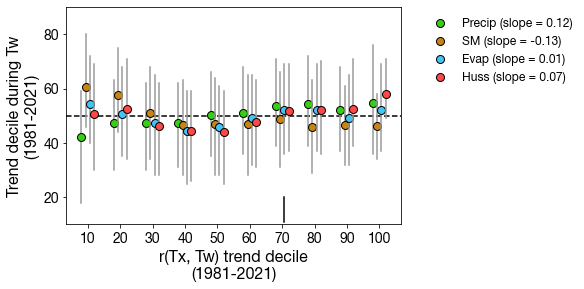

In [99]:

plt.figure(figsize=(6,4))
plt.xlim([0,31])
plt.ylim([10,90])
deciles = np.arange(10, 101, 10) 

plt.plot([0,31], [50,50], '--', color='k')

plt.plot([20.2,20.2], [11,20], '-k')

x = 2
offset=.4
for i in deciles:

 
    cur_x = x - .6
    y1 = np.nanpercentile(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1, label='Precip (slope = 0.12)')
    else:
        plt.plot([cur_x], [np.nanmean(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1)
        
    cur_x = x - .2
    y1 = np.nanpercentile(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#c98414', mew=1, label='SM (slope = -0.13)')
    else:
        plt.plot([cur_x], [np.nanmean(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#c98414', mew=1)
        
        
    cur_x = x + .2
    y1 = np.nanpercentile(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#42c5f5', mew=1, label='Evap (slope = 0.01)')
    else:
        plt.plot([cur_x], [np.nanmean(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#42c5f5', mew=1)
    
    
    cur_x = x + .6
    y1 = np.nanpercentile(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#ff4747', mew=1, label='Huss (slope = 0.07)')
    else:
        plt.plot([cur_x], [np.nanmean(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#ff4747', mew=1)
    
    
    x+=3


    
plt.xticks(np.arange(2,31,3))
plt.gca().set_xticklabels(deciles)
plt.xlabel('r(Tx, Tw) trend decile\n(1981-2021)')
plt.ylabel('Trend decile during Tw\n(1981-2021)')

plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('r(tx,tw)-pct-chg-vs-huss-evap-pr-sm-pct-on-tw-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'SM > 95th'), Text(1.7, 0, 'SM < 5th')]

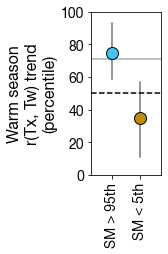

In [130]:
l1 = np.nanpercentile(era5_sm_trend_1d,5)
l2 = np.nanpercentile(era5_sm_trend_1d,95)

plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.ylim([0,100])
plt.plot([1,2], [zero_ind, zero_ind], '-', c='#aaaaaa')
plt.plot([1.3, 1.3], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_sm_trend_1d>l2], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_sm_trend_1d>l2], 75)], '-', c='#777777')
plt.plot([1.3], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_sm_trend_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)

plt.plot([1.7, 1.7], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_sm_trend_1d<l1], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_sm_trend_1d<l1], 75)], '-', c='#777777')
plt.plot([1.7], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_sm_trend_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)


plt.plot([1,2], [50,50], '--k')
plt.ylabel('Warm season\nr(Tx, Tw) trend\n(percentile)')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['SM > 95th', 'SM < 5th'])
# plt.savefig('r(tx,tw)-chg-tet-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'q adv +'), Text(1.7, 0, 'q adv -')]

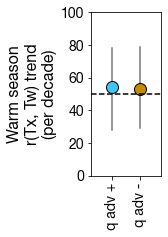

In [114]:
l1 = np.nanpercentile(era5_qadv_trend_1d,5)
l2 = np.nanpercentile(era5_qadv_trend_1d,95)

plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.ylim([0,100])
plt.plot([1.3, 1.3], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_qadv_trend_1d>l2], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_qadv_trend_1d>l2], 75)], '-', c='#777777')
plt.plot([1.3], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_qadv_trend_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)

plt.plot([1.7, 1.7], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_qadv_trend_1d<l1], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_qadv_trend_1d<l1], 75)], '-', c='#777777')
plt.plot([1.7], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_qadv_trend_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)

plt.plot([1,2], [50,50], '--k')
plt.ylabel('Warm season\nr(Tx, Tw) trend\n(per decade)')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['q adv +', 'q adv -'])
# plt.savefig('r(tx,tw)-chg-tet-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'T/ET > 90th'), Text(1.7, 0, 'T/ET < 10th')]

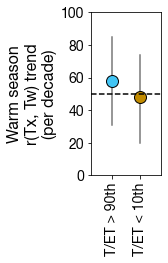

In [113]:
l1 = np.nanpercentile(era5_tet_trend_1d,5)
l2 = np.nanpercentile(era5_tet_trend_1d,95)

plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.ylim([0,100])
plt.plot([1.3, 1.3], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tet_trend_1d>l2], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tet_trend_1d>l2], 75)], '-', c='#777777')
plt.plot([1.3], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_tet_trend_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)

plt.plot([1.7, 1.7], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tet_trend_1d<l1], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tet_trend_1d<l1], 75)], '-', c='#777777')
plt.plot([1.7], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_tet_trend_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)

plt.plot([1,2], [50,50], '--k')
plt.ylabel('Warm season\nr(Tx, Tw) trend\n(per decade)')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['T/ET > 90th', 'T/ET < 10th'])
# plt.savefig('r(tx,tw)-chg-tet-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'Tran > 95th'), Text(1.7, 0, 'Tran < 5th')]

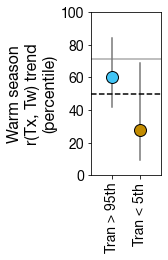

In [131]:
l1 = np.nanpercentile(era5_tran_trend_1d,5)
l2 = np.nanpercentile(era5_tran_trend_1d,95)

plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.ylim([0,100])
plt.plot([1,2], [zero_ind, zero_ind], '-', c='#aaaaaa')
plt.plot([1.3, 1.3], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tran_trend_1d>l2], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tran_trend_1d>l2], 75)], '-', c='#777777')
plt.plot([1.3], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_tran_trend_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)

plt.plot([1.7, 1.7], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tran_trend_1d<l1], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_tran_trend_1d<l1], 75)], '-', c='#777777')
plt.plot([1.7], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_tran_trend_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)

plt.plot([1,2], [50,50], '--k')
plt.ylabel('Warm season\nr(Tx, Tw) trend\n(percentile)')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['Tran > 95th', 'Tran < 5th'])
# plt.savefig('r(tx,tw)-chg-tran-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'Evap > 95th'), Text(1.7, 0, 'Evap < 5th')]

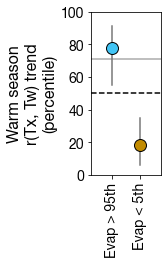

In [132]:
l1 = np.nanpercentile(era5_evap_trend_1d,5)
l2 = np.nanpercentile(era5_evap_trend_1d,95)

plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.ylim([0,100])
plt.plot([1,2], [zero_ind, zero_ind], '-', c='#aaaaaa')
plt.plot([1.3, 1.3], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_evap_trend_1d>l2], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_evap_trend_1d>l2], 75)], '-', c='#777777')
plt.plot([1.3], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_evap_trend_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)

plt.plot([1.7, 1.7], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_evap_trend_1d<l1], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_evap_trend_1d<l1], 75)], '-', c='#777777')
plt.plot([1.7], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_evap_trend_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)

plt.plot([1,2], [50,50], '--k')
plt.ylabel('Warm season\nr(Tx, Tw) trend\n(percentile)')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['Evap > 95th', 'Evap < 5th'])
# plt.savefig('r(tx,tw)-chg-evap-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'P > 95th'), Text(1.7, 0, 'P < 5th')]

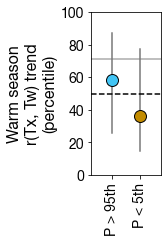

In [133]:
l1 = np.nanpercentile(era5_monthly_tp_trend_max_r2_1d,5)
l2 = np.nanpercentile(era5_monthly_tp_trend_max_r2_1d,95)

plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.ylim([0,100])
plt.plot([1,2], [zero_ind, zero_ind], '-', c='#aaaaaa')
plt.plot([1.3, 1.3], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_monthly_tp_trend_max_r2_1d>l2], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_monthly_tp_trend_max_r2_1d>l2], 75)], '-', c='#777777')
plt.plot([1.3], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_monthly_tp_trend_max_r2_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)

plt.plot([1.7, 1.7], [np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_monthly_tp_trend_max_r2_1d<l1], 25), 
                      np.nanpercentile(tx_tw_corr_trend_percentiles_1d[era5_monthly_tp_trend_max_r2_1d<l1], 75)], '-', c='#777777')
plt.plot([1.7], [np.nanmedian(tx_tw_corr_trend_percentiles_1d[era5_monthly_tp_trend_max_r2_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)

plt.plot([1,2], [50,50], '--k')
plt.ylabel('Warm season\nr(Tx, Tw) trend\n(percentile)')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['P > 95th', 'P < 5th'])
# plt.savefig('r(tx,tw)-chg-pr-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1.3, 0, 'r(Tx, Tw) +'), Text(1.7, 0, 'r(Tx, Tw) -')]

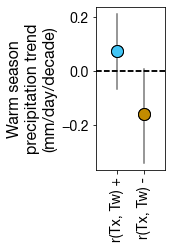

In [39]:
l1 = -.05
l2 = .05
plt.figure(figsize=(1.25,3))
plt.xlim([1,2])
plt.plot([1.3, 1.3], [np.nanpercentile(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d>l2], 25), 
                      np.nanpercentile(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d>l2], 75)], '-', c='#777777')

plt.plot([1.3, 1.3], [np.nanmean(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d>l2]), 
                      np.nanmean(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d>l2])], 'o', ms=12, mec='k', mfc='#42c5f5', mew=1)


plt.plot([1.7, 1.7], [np.nanpercentile(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d<l1], 25), 
                      np.nanpercentile(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d<l1], 75)], '-', c='#777777')

plt.plot([1.7, 1.7], [np.nanmean(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d<l1]), 
                      np.nanmean(era5_monthly_tp_trend_max_r2_1d[tx_tw_corr_trend_1d<l1])], 'o', ms=12, mec='k', mfc='#c28b00', mew=1)

plt.plot([1,2], [0,0], '--k')
plt.ylabel('Warm season\nprecipitation trend\n(mm/day/decade)')

plt.plot([1,2], [0,0], '--k')

plt.xticks([1.3, 1.7], rotation=90)
plt.gca().set_xticklabels(['r(Tx, Tw) +', 'r(Tx, Tw) -'])

In [41]:
v1 = tx_huss_corr_1d*10
v2 = tx_tw_corr_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.22
x2 = .12

plt.figure(figsize=(6,5))
plt.scatter(v1, v2, c=tx_sm_corr_1d*10, cmap='BrBG', vmin=-.15, vmax=.15)
c = plt.colorbar()
c.set_label('r(Tx, SM) trend (per decade)')
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('r(Tx, Tw) trend (per decade)')
plt.ylabel('r(Tx, Huss) trend (per decade)')
# plt.savefig('r(tx,tw)-vs-r(tx,huss)-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

NameError: name 'tx_huss_corr_1d' is not defined

Text(0, 0.5, '$Tw_{100}$ trend\n($\\degree$C/decade)')

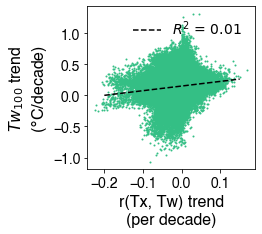

In [107]:
v1 = tx_tw_corr_1d * 10
v2 = tw_100_1d * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('$Tw_{100}$ trend\n($\degree$C/decade)')
# plt.savefig('r(tx,tw)-vs-tw_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

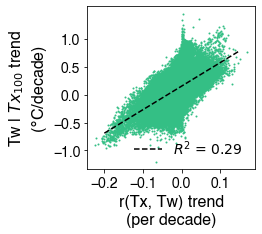

In [94]:
v1 = tx_tw_corr_1d * 10
v2 = tw_on_tx_100_1d * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tw | $Tx_{100}$ trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

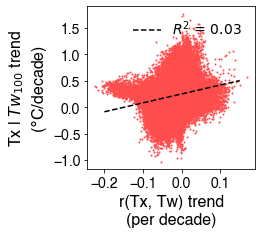

In [95]:
v1 = tx_tw_corr_1d*10
v2 = tx_on_tw_100_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.yticks([-1, -.5, 0, .5, 1, 1.5])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tx | $Tw_{100}$ trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tx_on_tw-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'SM | $Tx_{100}$ trend\n($m^3/m^3$/decade)')

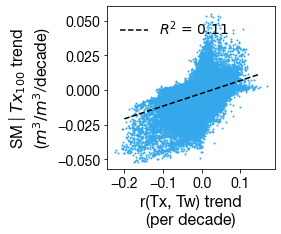

In [99]:
v1 = tx_tw_corr_1d*10
v2 = sm_on_tx_100_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34a8eb', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('SM | $Tx_{100}$ trend\n($m^3/m^3$/decade)')
# plt.savefig('r(tx,tw)-vs-sm_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

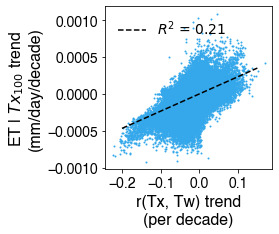

In [97]:
v1 = tx_tw_corr_1d*10
v2 = evap_on_tx_100_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34a8eb', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('ET | $Tx_{100}$ trend\n(mm/day/decade)')
plt.savefig('r(tx,tw)-vs-et_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'EF on 100th pct\nTx trend\n(mm/day/decade)')

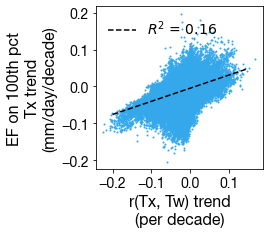

In [91]:
v1 = tx_tw_corr_1d*10
v2 = ef_on_tx_100_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34a8eb',s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('EF on 100th pct\nTx trend\n(mm/day/decade)')
# plt.savefig('r(tx,tw)-vs-ef_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'Warm season\nprecip trend\n(mm/day/decade)')

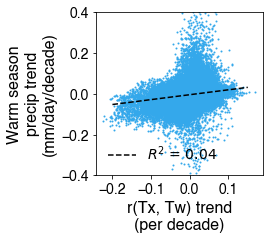

In [99]:
v1 = tx_tw_corr_1d*10
v2 = tp_on_tx_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.ylim([-.4, .4])
plt.scatter(v1, v2, c='#34a8eb',s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)

font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Warm season\nprecip trend\n(mm/day/decade)')
# plt.savefig('r(tx,tw)-vs-seasonal_precip-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'Huss | $Tx_{100}$ trend\n(kg/kg/decade)')

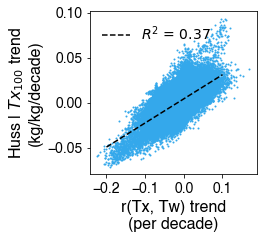

In [61]:

v1 = tx_tw_corr_1d*10
v2 = huss_on_tx_100_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .1

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34a8eb',s=1)

plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Huss | $Tx_{100}$ trend\n(kg/kg/decade)')
# plt.savefig('r(tx,tw)-vs-huss_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


Text(0, 0.5, 'Huss | $Tx_{100}$ trend\n(kg/kg/decade)')

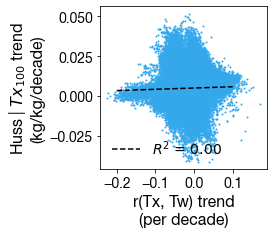

In [98]:

v1 = tx_tw_corr_1d*10
v2 = huss_on_tw_100_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .1

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34a8eb',s=1)

plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Huss | $Tx_{100}$ trend\n(kg/kg/decade)')
# plt.savefig('r(tx,tw)-vs-huss_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [1]:

v1 = tx_tw_corr_1d*10
v2 = tx_amp_1d*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .1

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34a8eb',s=1)

plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Huss | $Tx_{100}$ trend\n(kg/kg/decade)')
# plt.savefig('r(tx,tw)-vs-huss_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


NameError: name 'tx_tw_corr_1d' is not defined

In [90]:
p1 = -1
p2 = -11
p3 = 0

tw_100_1d = tw.tw_on_warm_season_trend[p1,:,:].values.reshape(tw.tw_on_warm_season_trend[p1,:,:].size)
tw_90_1d = tw.tw_on_warm_season_trend[-3,:,:].values.reshape(tw.tw_on_warm_season_trend[-3,:,:].size)
tw_80_1d = tw.tw_on_warm_season_trend[-5,:,:].values.reshape(tw.tw_on_warm_season_trend[-5,:,:].size)
tw_70_1d = tw.tw_on_warm_season_trend[-7,:,:].values.reshape(tw.tw_on_warm_season_trend[-7,:,:].size)
tw_60_1d = tw.tw_on_warm_season_trend[-9,:,:].values.reshape(tw.tw_on_warm_season_trend[-9,:,:].size)
tw_100_p_1d = tw.tw_on_warm_season_p_value[p1,:,:].values.reshape(tw.tw_on_warm_season_p_value[p1,:,:].size)
tw_50_1d = tw.tw_on_warm_season_trend[p2,:,:].values.reshape(tw.tw_on_warm_season_trend[p2,:,:].size)
tw_50_p_1d = tw.tw_on_warm_season_p_value[p1,:,:].values.reshape(tw.tw_on_warm_season_p_value[p2,:,:].size)

tw_amp = tw.tw_on_warm_season_trend[p1,:,:]-tw.tw_on_warm_season_trend[p2,:,:]
# tw_mean_1d = tw_era5_mean.tw.values.reshape(tw_era5_mean.tw.values.size)
tw_amp_1d = tw_amp.values.reshape(tw_amp.values.size)

tx_100_1d = tx.tx_on_warm_season_trend[p1,:,:].values.reshape(tx.tx_on_warm_season_trend[p1,:,:].size)
tx_90_1d = tx.tx_on_warm_season_trend[-3,:,:].values.reshape(tx.tx_on_warm_season_trend[-3,:,:].size)
tx_80_1d = tx.tx_on_warm_season_trend[-5,:,:].values.reshape(tx.tx_on_warm_season_trend[-5,:,:].size)
tx_70_1d = tx.tx_on_warm_season_trend[-7,:,:].values.reshape(tx.tx_on_warm_season_trend[-7,:,:].size)
tx_60_1d = tx.tx_on_warm_season_trend[-9,:,:].values.reshape(tx.tx_on_warm_season_trend[-9,:,:].size)
tx_50_1d = tx.tx_on_warm_season_trend[p2,:,:].values.reshape(tx.tx_on_warm_season_trend[p2,:,:].size)
tx_amp = tx.tx_on_warm_season_trend[p1,:,:]-tx.tx_on_warm_season_trend[p2,:,:]
# tx_mean_1d = tx_era5_mean.mx2t.values.reshape(tx_era5_mean.mx2t.values.size)
tx_amp_1d = tx_amp.values.reshape(tx_amp.values.size)

# huss_mean_1d = huss_era5_mean.q.values.reshape(huss_era5_mean.q.values.size)

sm_on_tx_100_1d = sm_on_tx_trends.sm_on_warm_season_tx_trend[-1,:,:].values.reshape(sm_on_tx_trends.sm_on_warm_season_tx_trend[-1,:,:].size)
sm_on_tx_50_1d = sm_on_tx_trends.sm_on_warm_season_tx_trend[-10,:,:].values.reshape(sm_on_tx_trends.sm_on_warm_season_tx_trend[-10,:,:].size)
sm_on_tx_amp = sm_on_tx_trends.sm_on_warm_season_tx_trend[-1,:,:]-sm_on_tx_trends.sm_on_warm_season_tx_trend[-10,:,:]
sm_on_tx_amp_1d = sm_on_tx_amp.values.reshape(sm_on_tx_amp.values.size)

huss_on_tx_100_1d = huss_on_tx_trend.huss_on_warm_season_tx_trend[-1,:,:].values.reshape(huss_on_tx_trend.huss_on_warm_season_tx_trend[-1,:,:].size)
huss_on_tx_50_1d = huss_on_tx_trend.huss_on_warm_season_tx_trend[-10,:,:].values.reshape(huss_on_tx_trend.huss_on_warm_season_tx_trend[-10,:,:].size)
huss_on_tx_amp = huss_on_tx_trend.huss_on_warm_season_tx_trend[-1,:,:]-huss_on_tx_trend.huss_on_warm_season_tx_trend[-10,:,:]
huss_on_tx_amp_1d = huss_on_tx_amp.values.reshape(huss_on_tx_amp.values.size)

evap_on_tx_100_1d = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-1,:,:].values.reshape(evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-1,:,:].size)
evap_on_tx_50_1d = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-10,:,:].values.reshape(evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-10,:,:].size)
evap_on_tx_amp = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-1,:,:]-evap_on_tx_trend.evaporation_on_warm_season_tx_trend[-10,:,:]
evap_on_tx_amp_1d = evap_on_tx_amp.values.reshape(evap_on_tx_amp.values.size)

# ef_on_tx_100_1d = ef_on_tx_trend.ef_on_warm_season_tx_trend[-1,:,:].values.reshape(ef_on_tx_trend.ef_on_warm_season_tx_trend[-1,:,:].size)
# ef_on_tx_50_1d = ef_on_tx_trend.ef_on_warm_season_tx_trend[-10,:,:].values.reshape(ef_on_tx_trend.ef_on_warm_season_tx_trend[-10,:,:].size)
# ef_on_tx_amp = ef_on_tx_trend.ef_on_warm_season_tx_trend[-1,:,:]-ef_on_tx_trend.ef_on_warm_season_tx_trend[-10,:,:]
# ef_on_tx_amp_1d = ef_on_tx_amp.values.reshape(ef_on_tx_amp.values.size)

gph500_on_tx_100_1d = gph500_on_tx_trend.gph500_on_tx_warm_season_trend[-1,:,:].values.reshape(gph500_on_tx_trend.gph500_on_tx_warm_season_trend[-1,:,:].size)
gph500_on_tx_50_1d = gph500_on_tx_trend.gph500_on_tx_warm_season_trend[-10,:,:].values.reshape(gph500_on_tx_trend.gph500_on_tx_warm_season_trend[-10,:,:].size)
gph500_on_tx_amp = gph500_on_tx_trend.gph500_on_tx_warm_season_trend[-1,:,:]-gph500_on_tx_trend.gph500_on_tx_warm_season_trend[-10,:,:]
gph500_on_tx_amp_1d = gph500_on_tx_amp.values.reshape(gph500_on_tx_amp.values.size)

tcc_on_tx_100_1d = tcc_on_tx_trend.tcc_on_tx_warm_season_trend[-1,:,:].values.reshape(tcc_on_tx_trend.tcc_on_tx_warm_season_trend[-1,:,:].size)
tcc_on_tx_50_1d = tcc_on_tx_trend.tcc_on_tx_warm_season_trend[-10,:,:].values.reshape(tcc_on_tx_trend.tcc_on_tx_warm_season_trend[-10,:,:].size)
tcc_on_tx_amp = tcc_on_tx_trend.tcc_on_tx_warm_season_trend[-1,:,:]-tcc_on_tx_trend.tcc_on_tx_warm_season_trend[-10,:,:]
tcc_on_tx_amp_1d = tcc_on_tx_amp.values.reshape(tcc_on_tx_amp.values.size)

cdd_on_tx_trend_1d = cdd_on_tx_trend.cdd_on_tx_warm_season_trend.values.reshape(cdd_on_tx_trend.cdd_on_tx_warm_season_trend.size)
q_adv_on_tx_trend_1d = q_adv_on_tx_trend.q_adv_on_tx_warm_season_trend[-1,:,:].values.reshape(q_adv_on_tx_trend.q_adv_on_tx_warm_season_trend[-1,:,:].values.size)


tran_warm_season_1d = tran_warm_season_trend.tran_on_warm_season_trend.values.reshape([tran_warm_season_trend.tran_on_warm_season_trend.values.size])
tet_warm_season_1d = tet_warm_season_trend.tet_on_warm_season_trend.values.reshape([tet_warm_season_trend.tet_on_warm_season_trend.values.size])
tet_warm_season_1d[abs(tet_warm_season_1d)>.005]=np.nan


# gph500_on_tw_100_1d = gph500_on_tw_trend.gph500_on_tw_warm_season_trend[-1,:,:].values.reshape(gph500_on_tw_trend.gph500_on_tw_warm_season_trend[-1,:,:].size)
# gph500_on_tw_50_1d = gph500_on_tw_trend.gph500_on_tw_warm_season_trend[-10,:,:].values.reshape(gph500_on_tw_trend.gph500_on_tw_warm_season_trend[-10,:,:].size)
# gph500_on_tw_amp = gph500_on_tw_trend.gph500_on_tw_warm_season_trend[-1,:,:]-gph500_on_tw_trend.gph500_on_tw_warm_season_trend[-10,:,:]
# gph500_on_tw_amp_1d = gph500_on_tw_amp.values.reshape(gph500_on_tw_amp.values.size)

tw_on_tx_100_1d = tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:].values.reshape(tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:].size)
tw_on_tx_50_1d = tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:].values.reshape(tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:].size)
tw_on_tx_amp = tw_on_tx_trend.tw_on_warm_season_tx_trend[-1,:,:]-tw_on_tx_trend.tw_on_warm_season_tx_trend[-10,:,:]
tw_on_tx_amp_1d = tw_on_tx_amp.values.reshape(tw_on_tx_amp.values.size)

tp_on_tx_1d = tp_on_tx_trend.tp_on_tx_warm_season_trend.values.reshape([tp_on_tx_trend.tp_on_tx_warm_season_trend.values.size])
tp_on_tw_1d = tp_on_tw_trend.tp_on_tw_warm_season_trend.values.reshape([tp_on_tw_trend.tp_on_tw_warm_season_trend.values.size])
tp_on_tx_100_trend_1d = tp_on_tx_deciles_trend['tp_on_tx_warm_season_trend'][-1,:,:].values.reshape([tp_on_tx_deciles_trend['tp_on_tx_warm_season_trend'][-1,:,:].values.size])


tx_tw_corr_1d = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape([tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size])
tx_tw_corr_mean_1d = tx_tw_corr_mean.tx_tw_corr.values.reshape([tx_tw_corr_mean.tx_tw_corr.values.size])
tx_sm_corr_1d = tx_sm_corr_trend.tx_sm_corr_warm_season_trend.values.reshape([tx_sm_corr_trend.tx_sm_corr_warm_season_trend.values.size])
tx_huss_corr_1d = tx_huss_corr_trend.tx_huss_corr_warm_season_trend.values.reshape([tx_huss_corr_trend.tx_huss_corr_warm_season_trend.values.size])
huss_sm_corr_1d = huss_sm_corr_trend.huss_sm_corr_warm_season_trend.values.reshape([huss_sm_corr_trend.huss_sm_corr_warm_season_trend.values.size])

txx_day_trend_1d = txx_day_trend['txx_day_warm_season_trend'].values.reshape([txx_day_trend['txx_day_warm_season_trend'].values.size])

huss_on_tw_100_1d = huss_on_tw_trend.huss_on_warm_season_tw_trend[-1,:,:].values.reshape(huss_on_tw_trend.huss_on_warm_season_tw_trend[-1,:,:].size)
huss_on_tw_50_1d = huss_on_tw_trend.huss_on_warm_season_tw_trend[-10,:,:].values.reshape(huss_on_tw_trend.huss_on_warm_season_tw_trend[-10,:,:].size)
huss_on_tw_amp = huss_on_tw_trend.huss_on_warm_season_tw_trend[-1,:,:]-huss_on_tw_trend.huss_on_warm_season_tw_trend[-10,:,:]
huss_on_tw_amp_1d = huss_on_tw_amp.values.reshape(huss_on_tw_amp.values.size)

evap_on_tw_100_1d = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-1,:,:].values.reshape(evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-1,:,:].size)
evap_on_tw_50_1d = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-10,:,:].values.reshape(evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-10,:,:].size)
evap_on_tw_amp = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-1,:,:]-evap_on_tw_trend.evaporation_on_warm_season_tw_trend[-10,:,:]
evap_on_tw_amp_1d = evap_on_tw_amp.values.reshape(evap_on_tw_amp.values.size)

sm_on_tw_100_1d = sm_on_tw_trends.sm_on_warm_season_tw_trend[-1,:,:].values.reshape(sm_on_tw_trends.sm_on_warm_season_tw_trend[-1,:,:].size)
sm_on_tw_50_1d = sm_on_tw_trends.sm_on_warm_season_tw_trend[-10,:,:].values.reshape(sm_on_tw_trends.sm_on_warm_season_tw_trend[-10,:,:].size)
sm_on_tw_amp = sm_on_tw_trends.sm_on_warm_season_tw_trend[-1,:,:]-sm_on_tw_trends.sm_on_warm_season_tw_trend[-10,:,:]
sm_on_tw_amp_1d = sm_on_tw_amp.values.reshape(sm_on_tw_amp.values.size)

tx_on_tw_100_1d = tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:].values.reshape(tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:].size)
tx_on_tw_50_1d = tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:].values.reshape(tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:].size)
tx_on_tw_amp = tx_on_tw_trend.tx_on_warm_season_tw_trend[-1,:,:]-tx_on_tw_trend.tx_on_warm_season_tw_trend[-10,:,:]
tx_on_tw_amp_1d = tx_on_tw_amp.values.reshape(tx_on_tw_amp.values.size)

Text(0, 0.5, 'Tw | $Tx_{100}$ - $Tw_{100}$')

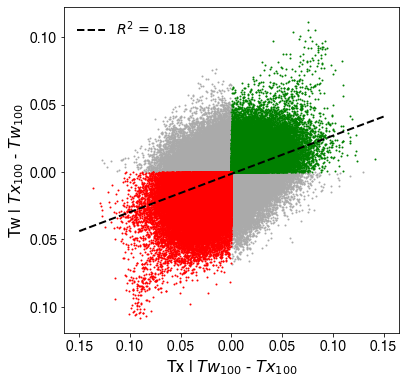

In [67]:
v1 = tx_on_tw_100_1d - tx_100_1d
v2 = tw_on_tx_100_1d - tw_100_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.15
x2 = .15

plt.figure(figsize=(6,6))
plt.scatter(v1[np.where((v1<0) & (v2>0))[0]], v2[np.where((v1<0) & (v2>0))[0]], c='#aaaaaa', s=1)
plt.scatter(v1[np.where((v1>0) & (v2<0))[0]], v2[np.where((v1>0) & (v2<0))[0]], c='#aaaaaa', s=1)
plt.scatter(v1[np.where((v1>0) & (v2>0))[0]], v2[np.where((v1>0) & (v2>0))[0]], c='g', s=1)
plt.scatter(v1[np.where((v1<0) & (v2<0))[0]], v2[np.where((v1<0) & (v2<0))[0]], c='r', s=1)

plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

plt.xlabel('Tx | $Tw_{100}$ - $Tx_{100}$')
plt.ylabel('Tw | $Tx_{100}$ - $Tw_{100}$')

In [128]:
ind_cov = np.where((v1 > 0) & (v2 > 0))[0]
ind_div = np.where((v1 < 0) & (v2 < 0))[0]
ind_tx_no_tw = np.where((v1 > 0) & (v2 < 0))[0]
ind_tw_no_tx = np.where((v1 < 0) & (v2 > 0))[0]
ind_other = np.where( ((v1 > 0) & (v2 < 0)) | ((v1 < 0) & (v2 > 0)))[0]

In [131]:
ind_div.size

80706

In [125]:
amp1_p = 10

amp2_p = range(11,20,1)
amp2_sm_p = range(11, 20, 1)

tx_amp_by_level = []
tw_amp_by_level = []
huss_on_tw_amp_by_level = []
huss_on_tx_amp_by_level = []
evap_on_tw_amp_by_level = []
evap_on_tx_amp_by_level = []
sm_on_tx_amp_by_level = []
sm_on_tw_amp_by_level = []
gph500_on_tx_amp_by_level = []

tx_sm_slope_by_level = []
tx_sm_r2_by_level = []
tx_huss_slope_by_level = []
tx_huss_r2_by_level = []
tx_evap_slope_by_level = []
tx_evap_r2_by_level = []
tx_gph500_slope_by_level = []
tx_gph500_r2_by_level = []

tw_huss_slope_by_level = []
tw_huss_r2_by_level = []
tw_evap_slope_by_level = []
tw_evap_r2_by_level = []
tw_sm_slope_by_level = []
tw_sm_r2_by_level = []

huss_evap_slope_by_level = []
huss_evap_r2_by_level = []

for i in range(len(amp2_p)):
    cur_tx_amp = tx.tx_on_warm_season_trend[amp2_p[i],:,:]-tx.tx_on_warm_season_trend[amp1_p,:,:]
    cur_tx_amp_1d = cur_tx_amp.values.reshape(cur_tx_amp.values.size)
    
    cur_tw_amp = tw.tw_on_warm_season_trend[amp2_p[i],:,:]-tw.tw_on_warm_season_trend[amp1_p,:,:]
    cur_tw_amp_1d = cur_tw_amp.values.reshape(cur_tw_amp.values.size)
    
    cur_huss_on_tw_amp = huss_on_tw_trend.huss_on_warm_season_tw_trend[amp2_sm_p[i],:,:]-huss_on_tw_trend.huss_on_warm_season_tw_trend[10,:,:]
    cur_huss_on_tw_amp_1d = cur_huss_on_tw_amp.values.reshape(cur_huss_on_tw_amp.values.size)
    
    cur_huss_on_tx_amp = huss_on_tx_trend.huss_on_warm_season_tx_trend[amp2_sm_p[i],:,:]-huss_on_tx_trend.huss_on_warm_season_tx_trend[10,:,:]
    cur_huss_on_tx_amp_1d = cur_huss_on_tx_amp.values.reshape(cur_huss_on_tx_amp.values.size)
    
    cur_evap_on_tw_amp = evap_on_tw_trend.evaporation_on_warm_season_tw_trend[amp2_sm_p[i],:,:]-evap_on_tw_trend.evaporation_on_warm_season_tw_trend[10,:,:]
    cur_evap_on_tw_amp_1d = cur_evap_on_tw_amp.values.reshape(cur_evap_on_tw_amp.values.size)
    
    cur_evap_on_tx_amp = evap_on_tx_trend.evaporation_on_warm_season_tx_trend[amp2_sm_p[i],:,:]-evap_on_tx_trend.evaporation_on_warm_season_tx_trend[10,:,:]
    cur_evap_on_tx_amp_1d = cur_evap_on_tx_amp.values.reshape(cur_evap_on_tx_amp.values.size)
    
    cur_sm_on_tw_amp = sm_on_tw_trends.sm_on_warm_season_tw_trend[amp2_sm_p[i],:,:]-sm_on_tw_trends.sm_on_warm_season_tw_trend[10,:,:]
    cur_sm_on_tw_amp_1d = cur_sm_on_tw_amp.values.reshape(sm_on_tw_amp.values.size)
    
    cur_sm_on_tx_amp = sm_on_tx_trends.sm_on_warm_season_tx_trend[amp2_sm_p[i],:,:]-sm_on_tx_trends.sm_on_warm_season_tx_trend[10,:,:]
    cur_sm_on_tx_amp_1d = cur_sm_on_tx_amp.values.reshape(cur_sm_on_tx_amp.values.size)
    
    cur_gph500_on_tx_amp = gph500_on_tx_trend.gph500_on_tx_warm_season_trend[amp2_sm_p[i],:,:]-gph500_on_tx_trend.gph500_on_tx_warm_season_trend[10,:,:]
    cur_gph500_on_tx_amp_1d = cur_gph500_on_tx_amp.values.reshape(cur_gph500_on_tx_amp.values.size)
    
    
    
    tx_amp_by_level.append(np.nanmean(cur_tx_amp_1d))
    tw_amp_by_level.append(np.nanmean(cur_tw_amp_1d))
    huss_on_tw_amp_by_level.append(np.nanmean(cur_huss_on_tw_amp_1d))
    huss_on_tx_amp_by_level.append(np.nanmean(cur_huss_on_tx_amp_1d))
    evap_on_tw_amp_by_level.append(np.nanmean(cur_evap_on_tw_amp_1d))
    evap_on_tx_amp_by_level.append(np.nanmean(cur_evap_on_tx_amp_1d))
    sm_on_tx_amp_by_level.append(np.nanmean(cur_sm_on_tx_amp_1d))
    sm_on_tw_amp_by_level.append(np.nanmean(cur_sm_on_tw_amp_1d))
    gph500_on_tx_amp_by_level.append(np.nanmean(cur_gph500_on_tx_amp_1d))
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_sm_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_sm_on_tx_amp_1d[nn], X).fit()
    tx_sm_slope_by_level.append(mdl.params[1])
    tx_sm_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_huss_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_huss_on_tx_amp_1d[nn], X).fit()
    tx_huss_slope_by_level.append(mdl.params[1])
    tx_huss_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_evap_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_evap_on_tx_amp_1d[nn], X).fit()
    tx_evap_slope_by_level.append(mdl.params[1])
    tx_evap_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tx_amp_1d)) & (~np.isnan(cur_gph500_on_tx_amp_1d)))[0]
    X = sm.add_constant(cur_tx_amp_1d[nn])
    mdl = sm.OLS(cur_gph500_on_tx_amp_1d[nn], X).fit()
    tx_gph500_slope_by_level.append(mdl.params[1])
    tx_gph500_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tw_amp_1d)) & (~np.isnan(cur_huss_on_tw_amp_1d)))[0]
    X = sm.add_constant(cur_tw_amp_1d[nn])
    mdl = sm.OLS(cur_huss_on_tw_amp_1d[nn], X).fit()
    tw_huss_slope_by_level.append(mdl.params[1])
    tw_huss_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tw_amp_1d)) & (~np.isnan(cur_evap_on_tw_amp_1d)))[0]
    X = sm.add_constant(cur_tw_amp_1d[nn])
    mdl = sm.OLS(cur_evap_on_tw_amp_1d[nn], X).fit()
    tw_evap_slope_by_level.append(mdl.params[1])
    tw_evap_r2_by_level.append(mdl.rsquared)
    
    nn = np.where((~np.isnan(cur_tw_amp_1d)) & (~np.isnan(cur_sm_on_tw_amp_1d)))[0]
    X = sm.add_constant(cur_tw_amp_1d[nn])
    mdl = sm.OLS(cur_sm_on_tw_amp_1d[nn], X).fit()
    tw_sm_slope_by_level.append(mdl.params[1])
    tw_sm_r2_by_level.append(mdl.rsquared)
    
    
    
#     nn = np.where((~np.isnan(cur_huss_amp_1d)) & (~np.isnan(cur_evap_on_tw_amp_1d)))[0]
#     X = sm.add_constant(cur_huss_amp_1d[nn])
#     mdl = sm.OLS(cur_evap_on_tw_amp_1d[nn], X).fit()
#     huss_evap_slope_by_level.append(mdl.params[1])
#     huss_evap_r2_by_level.append(mdl.rsquared)
    

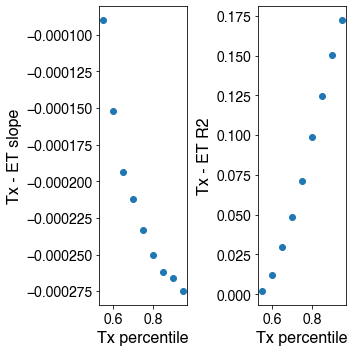

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].scatter(evap_on_tx_trend['quantile'][amp2_p], tx_evap_slope_by_level)
ax[0].set_ylabel('Tx - ET slope')
ax[0].set_xlabel('Tx percentile')
ax[1].scatter(evap_on_tx_trend['quantile'][amp2_p], tx_evap_r2_by_level)
ax[1].set_ylabel('Tx - ET R2')
ax[1].set_xlabel('Tx percentile')
plt.tight_layout()

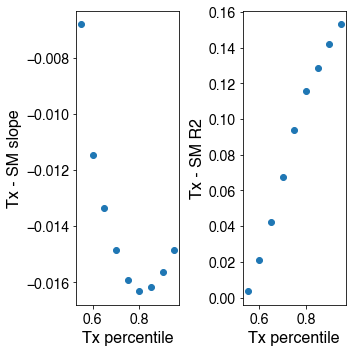

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].scatter(evap_on_tx_trend['quantile'][amp2_p], tx_sm_slope_by_level)
ax[0].set_ylabel('Tx - SM slope')
ax[0].set_xlabel('Tx percentile')
ax[1].scatter(evap_on_tx_trend['quantile'][amp2_p], tx_sm_r2_by_level)
ax[1].set_ylabel('Tx - SM R2')
ax[1].set_xlabel('Tx percentile')
plt.tight_layout()

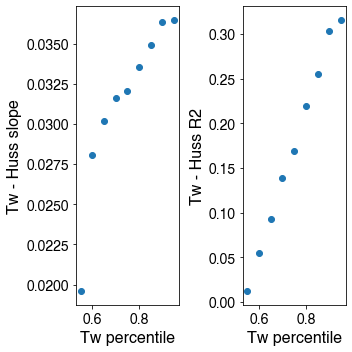

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].scatter(evap_on_tx_trend['quantile'][amp2_p], tw_huss_slope_by_level)
ax[0].set_ylabel('Tw - Huss slope')
ax[0].set_xlabel('Tw percentile')
ax[1].scatter(evap_on_tx_trend['quantile'][amp2_p], tw_huss_r2_by_level)
ax[1].set_ylabel('Tw - Huss R2')
ax[1].set_xlabel('Tw percentile')
plt.tight_layout()

Text(0, 0.5, 'Tx amp')

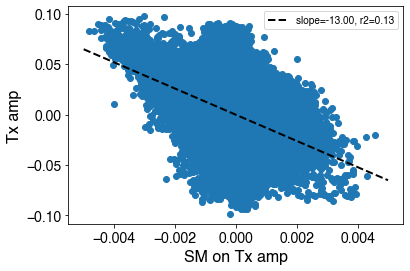

In [38]:
nn = np.where((~np.isnan(tx_amp_1d)) & (~np.isnan(sm_on_tx_amp_1d)))[0]
X = sm.add_constant(sm_on_tx_amp_1d[nn])
mdl = sm.OLS(tx_amp_1d[nn], X).fit()
plt.scatter(sm_on_tx_amp_1d, tx_amp_1d)
x1 = -.005
x2 = .005
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='slope=%.2f, r2=%.2f'%(mdl.params[1], mdl.rsquared))
plt.legend()
plt.xlabel('SM on Tx amp')
plt.ylabel('Tx amp')

In [88]:
import pandas as pd

# Assuming var3_amp_1d is your third variable
nn = np.where((~np.isnan(tx_amp_1d)) &  (~np.isnan(sm_on_tx_amp_1d)))[0]

# Create a DataFrame with three columns and name each column
X = pd.DataFrame({
    'gph500_on_tx_amp': gph500_on_tx_amp_1d[nn],
    'sm_on_tx_amp': sm_on_tx_amp_1d[nn],
#     'huss_on_tx_amp': huss_on_tx_amp_1d[nn],
    'evap_on_tx_amp': evap_on_tx_amp_1d[nn]
})

# Add a constant (intercept term) to the DataFrame
X = sm.add_constant(X)

# Fit the model
mdl = sm.OLS(tx_amp_1d[nn], X).fit()

print(mdl.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 2.392e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:40:25   Log-Likelihood:             4.6907e+05
No. Observations:              181732   AIC:                        -9.381e+05
Df Residuals:                  181728   BIC:                        -9.381e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0009   4.44e-05  

In [52]:
import pandas as pd

# Assuming var3_amp_1d is your third variable
nn = np.where((~np.isnan(tw_amp_1d)) & (~np.isnan(sm_on_tw_amp_1d)) & (~np.isnan(huss_on_tw_amp_1d)) & (~np.isnan(evap_on_tw_amp_1d)))[0]

# Create a DataFrame with three columns and name each column
X = pd.DataFrame({
    'tx_on_tw_amp': tx_on_tw_amp_1d[nn],
#     'sm_on_tw_amp_1d': sm_on_tw_amp_1d[nn],
#     'evap_on_tw_amp_1d': evap_on_tw_amp_1d[nn],
    'huss_on_tw_amp_1d': huss_on_tw_amp_1d[nn]
})

# Add a constant (intercept term) to the DataFrame
X = sm.add_constant(X)

# Fit the model
mdl = sm.OLS(tw_amp_1d[nn], X).fit()

print(mdl.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 5.164e+04
Date:                Mon, 26 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:39:14   Log-Likelihood:             5.4477e+05
No. Observations:              181732   AIC:                        -1.090e+06
Df Residuals:                  181729   BIC:                        -1.090e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0019   2.88e-0

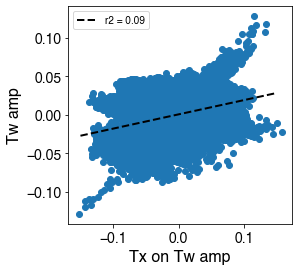

In [376]:
nn = np.where((~np.isnan(tw_amp_1d)) & (~np.isnan(tx_on_tw_amp_1d)))[0]
X = sm.add_constant(tx_on_tw_amp_1d[nn])
mdl = sm.OLS(tw_amp_1d[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(tx_on_tw_amp_1d, tw_amp_1d)
x1 = -.15
x2 = .15
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='r2 = %.2f'%mdl.rsquared)
plt.xlabel('Tx on Tw amp')
plt.ylabel('Tw amp')
plt.legend()
# mdl.summary()

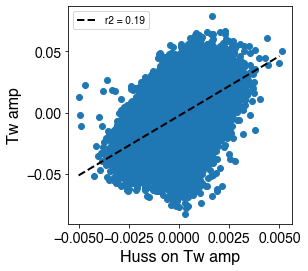

In [41]:
nn = np.where((~np.isnan(tw_amp_1d)) & (~np.isnan(huss_on_tw_amp_1d)))[0]
X = sm.add_constant(huss_on_tw_amp_1d[nn])
mdl = sm.OLS(tw_amp_1d[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(huss_on_tw_amp_1d, tw_amp_1d)
x1 = -.005
x2 = .005
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='r2 = %.2f'%mdl.rsquared)
plt.xlabel('Huss on Tw amp')
plt.ylabel('Tw amp')
plt.legend()
# mdl.summary()

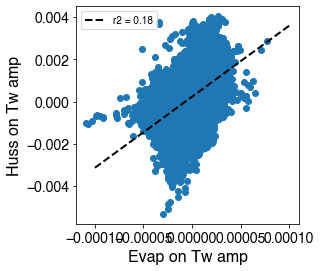

In [406]:
nn = np.where((~np.isnan(huss_on_tw_amp_1d)) & (~np.isnan(evap_on_tw_amp_1d)))[0]
X = sm.add_constant(evap_on_tw_amp_1d[nn])
mdl = sm.OLS(huss_on_tw_amp_1d[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(evap_on_tw_amp_1d, huss_on_tw_amp_1d)
x1 = -.0001
x2 = .0001
plt.plot([x1,x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=2, label='r2 = %.2f'%mdl.rsquared)
plt.xlabel('Evap on Tw amp')
plt.ylabel('Huss on Tw amp')
plt.legend()
# mdl.summary()

Text(0, 0.5, 'TW 99th percentile trend')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


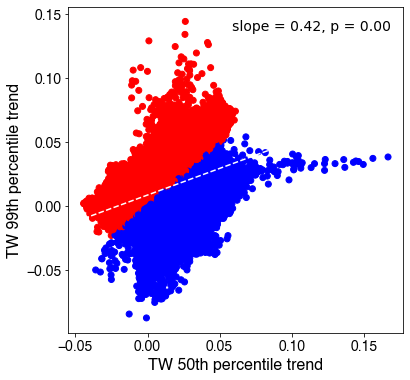

In [26]:
nn = np.where((~np.isnan(tw_100_1d)) & (~np.isnan(tw_50_1d)))[0]
X = sm.add_constant(tw_50_1d[nn])
mdl = sm.OLS(tw_100_1d[nn], X).fit()



x1 = np.nanmin(tw_50_1d)
x2 = np.nanmax(tw_50_1d)
plt.figure(figsize=(6,6))
plt.scatter(tw_50_1d[nn], tw_100_1d[nn], c=(tw_100_1d[nn]>tw_50_1d[nn]), cmap='bwr')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--w', label='slope = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
# plt.plot([x1,x2], [0,0], '-k', lw=2)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xlabel('TW %dth percentile trend'%p2)
plt.ylabel('TW %dth percentile trend'%p1)